# Energy Theft Detection using image transformation technique and tiled convolutional neural network

[Reference]
Encoding Time Series as Images for Visual Inspection and Classification Using Tiled Convolutional Neural Networks, ZhiguangWang and Tim Oates, Trajectory-Based Behavior Analytics: Papers from the 2015 AAAI Workshop, 2015.

In [1]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader, random_split
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, accuracy_score
import seaborn as sns

In [2]:
# Read data
df = pd.read_csv("data.csv", index_col=0)
df

,FLAG,2014/1/1,2014/1/10,2014/1/11,2014/1/12,2014/1/13,2014/1/14,2014/1/15,2014/1/16,2014/1/17,...,2016/9/28,2016/9/29,2016/9/3,2016/9/30,2016/9/4,2016/9/5,2016/9/6,2016/9/7,2016/9/8,2016/9/9
CONS_NO,,,,,,,,,,,,,,,,,,,,,
0387DD8A07E07FDA6271170F86AD9151,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.12,9.96,16.92,7.60,27.22,18.05,26.47,18.75,17.84,14.92
01D6177B5D4FFE0CABA9EF17DAFC2B84,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4B75AC4F2D8434CFF62DB64D0BB43103,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B32AC8CC6D5D805AC053557AB05F5343,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.50,9.99,11.78,18.59,26.80,18.57,14.59,12.82,19.37,15.92
EDFC78B07BA2908B3395C4EB2304665E,1,2.90,3.42,3.81,4.58,3.56,4.25,3.86,3.53,3.41,...,17.77,10.37,15.32,13.51,12.23,14.68,16.35,18.14,18.41,17.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F1472871E1AFF49D4289564B6377D76C,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.25,3.56,3.38,4.39,3.72,3.77,3.96,3.64,3.40,4.38
F3C8BBCD2DC26C1E0249DEEF6A4256B7,0,2.70,4.39,3.95,0.00,0.00,0.00,0.00,0.00,0.00,...,4.81,4.87,4.48,3.67,3.31,4.58,3.33,3.19,4.57,4.00
A9A0FE83467A680FBFB0DBFC910DF227,0,0.58,0.84,1.61,0.90,0.60,0.82,0.89,0.03,0.73,...,NaN,0.66,2.92,2.36,3.86,4.28,3.37,6.67,2.44,1.15


In [3]:
# Check missing values
df.isnull().sum(axis=1).value_counts() / df.shape[1]

730    5.196135
1      1.434783
5      1.323671
3      1.044444
732    0.895652
         ...   
634    0.000966
992    0.000966
788    0.000966
850    0.000966
687    0.000966
Name: count, Length: 915, dtype: float64

<Axes: xlabel='ratio of NA', ylabel='number of consumers'>

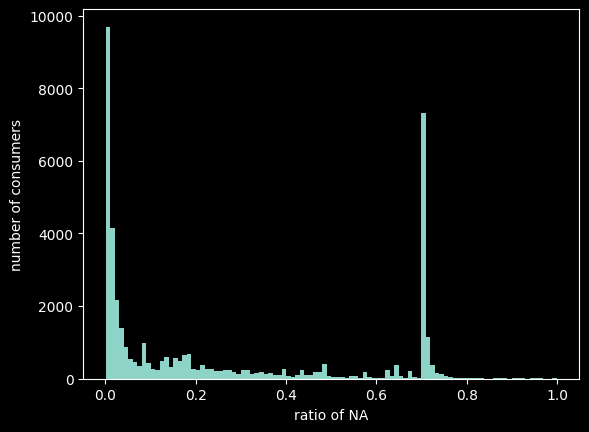

In [4]:
# Display histogram of the number of missing values in each row (across all columns)
na_ratio = df.isnull().sum(axis=1) / df.shape[1]
na_ratio.plot(kind='hist', xlabel='ratio of NA', ylabel='number of consumers', bins=100)


In [5]:
# Check the ratio of 'FLAG' - 1: Abnormal(Energy Theft), 0: Normal
print(df['FLAG'].sum())
print(df['FLAG'].sum() / df.shape[0])

3615
0.08531577456811101


In [6]:
# Remove rows with more than 35 percent missing values
df = df[(df.isnull().sum(axis=1) / df.shape[1]) < 0.35]
print(df.shape)

(28949, 1035)


In [7]:
# Remove rows which have 0 values but 'FLAG'
df = df[df.iloc[:, :-1].sum(axis=1) > 0.0]
print(df.shape)

(27784, 1035)


In [8]:
print(df['FLAG'].sum())
print(df['FLAG'].sum() / df.shape[0])

2166
0.07795853728764757


In [9]:
df_flag = df['FLAG']
df = df.drop(['FLAG'], axis=1)
df_flag

CONS_NO
EDFC78B07BA2908B3395C4EB2304665E    1
34C1954AA3703C4F8BD8EAEA7C4B7B83    1
768309B0EB11FD436CEE5ABFB84F4C0C    1
516954F5FF177CE314656D727FCC66A5    1
E34D1B467A365835A4A8AAD9395D49AA    1
                                   ..
5FCE503B6B616D5023B3C46173383107    0
F1472871E1AFF49D4289564B6377D76C    0
F3C8BBCD2DC26C1E0249DEEF6A4256B7    0
A9A0FE83467A680FBFB0DBFC910DF227    0
D9A6ADA018FA46A55D5438370456AA45    0
Name: FLAG, Length: 27784, dtype: int64

In [10]:
# remove rows where sum values is 0
df = df[df.sum(axis=1)!=0]

In [11]:
df = df.T

In [12]:
df.index = pd.to_datetime(df.index)

In [13]:
df

CONS_NO,EDFC78B07BA2908B3395C4EB2304665E,34C1954AA3703C4F8BD8EAEA7C4B7B83,768309B0EB11FD436CEE5ABFB84F4C0C,516954F5FF177CE314656D727FCC66A5,E34D1B467A365835A4A8AAD9395D49AA,9F61C13255D1183B179753742A24BFAD,F1D26619E4BC428924BAF5261F705D18,EB2DCE9143BF42A1C7E5E218BB77B6A6,E89F2AD4B103F2E2045EE0F4E60429BC,441D4A577AAD02F6C003644640C2619C,...,2A32029199A137504FB925D214AF20E9,1C6A4E84B6CE1105A01EECC4955FE4AC,9B3DC5E19AC7BE97FBE1A65F4A115CC4,1DF750822A991C356E86556CF5A64955,8C864A692CC5840072CF3BEBDA3CA8DB,5FCE503B6B616D5023B3C46173383107,F1472871E1AFF49D4289564B6377D76C,F3C8BBCD2DC26C1E0249DEEF6A4256B7,A9A0FE83467A680FBFB0DBFC910DF227,D9A6ADA018FA46A55D5438370456AA45
2014-01-01,2.90,0.11,0.91,11.02,NaN,1.91,5.20,0.00,6.03,19.92,...,NaN,NaN,148.40,0.00,5.22,NaN,NaN,2.70,0.58,16.89
2014-01-10,3.42,0.53,0.86,8.24,NaN,1.82,8.03,0.00,7.29,0.00,...,NaN,NaN,174.02,0.00,0.00,NaN,NaN,4.39,0.84,13.84
2014-01-11,3.81,0.45,1.10,7.94,NaN,1.07,8.11,0.00,4.86,0.00,...,NaN,NaN,122.26,0.00,15.96,NaN,NaN,3.95,1.61,13.50
2014-01-12,4.58,0.51,0.66,7.92,NaN,1.33,2.47,0.00,8.85,12.68,...,NaN,NaN,133.16,0.00,14.53,NaN,NaN,0.00,0.90,14.60
2014-01-13,3.56,1.32,5.82,8.31,NaN,1.97,1.51,0.00,5.73,15.48,...,NaN,NaN,173.65,0.00,15.43,NaN,NaN,0.00,0.60,14.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-09-05,14.68,1.36,4.61,108.69,5.81,15.18,15.56,0.00,12.25,13.54,...,3.92,13.08,283.51,1.83,4.75,1.29,3.77,4.58,4.28,18.11
2016-09-06,16.35,0.56,3.13,87.88,4.61,21.83,15.82,0.00,1.33,13.25,...,2.99,10.90,303.76,1.39,6.94,0.67,3.96,3.33,3.37,19.31
2016-09-07,18.14,1.02,3.10,86.36,4.78,24.30,14.67,0.32,0.08,14.18,...,5.00,11.57,285.34,7.50,4.55,0.76,3.64,3.19,6.67,17.48
2016-09-08,18.41,1.96,3.74,81.51,4.21,11.58,17.46,0.00,0.15,12.92,...,6.12,10.90,282.57,4.40,6.12,1.16,3.40,4.57,2.44,17.20


In [14]:
df = df.sort_index()
df

CONS_NO,EDFC78B07BA2908B3395C4EB2304665E,34C1954AA3703C4F8BD8EAEA7C4B7B83,768309B0EB11FD436CEE5ABFB84F4C0C,516954F5FF177CE314656D727FCC66A5,E34D1B467A365835A4A8AAD9395D49AA,9F61C13255D1183B179753742A24BFAD,F1D26619E4BC428924BAF5261F705D18,EB2DCE9143BF42A1C7E5E218BB77B6A6,E89F2AD4B103F2E2045EE0F4E60429BC,441D4A577AAD02F6C003644640C2619C,...,2A32029199A137504FB925D214AF20E9,1C6A4E84B6CE1105A01EECC4955FE4AC,9B3DC5E19AC7BE97FBE1A65F4A115CC4,1DF750822A991C356E86556CF5A64955,8C864A692CC5840072CF3BEBDA3CA8DB,5FCE503B6B616D5023B3C46173383107,F1472871E1AFF49D4289564B6377D76C,F3C8BBCD2DC26C1E0249DEEF6A4256B7,A9A0FE83467A680FBFB0DBFC910DF227,D9A6ADA018FA46A55D5438370456AA45
2014-01-01,2.90,0.11,0.91,11.02,NaN,1.91,5.20,0.00,6.03,19.92,...,NaN,NaN,148.40,0.00,5.22,NaN,NaN,2.70,0.58,16.89
2014-01-02,5.64,0.11,1.16,7.92,NaN,2.11,2.35,0.00,3.18,14.81,...,NaN,NaN,159.86,0.00,5.04,NaN,NaN,0.00,1.16,15.15
2014-01-03,6.99,0.25,0.75,8.41,NaN,1.69,2.56,0.01,3.33,13.11,...,NaN,NaN,157.20,0.00,4.92,NaN,NaN,0.00,0.92,19.28
2014-01-04,3.32,0.27,1.30,9.66,NaN,1.72,1.46,0.00,7.26,14.51,...,NaN,NaN,104.80,0.00,4.88,NaN,NaN,5.72,0.98,17.19
2014-01-05,3.61,0.21,0.74,9.86,NaN,1.31,2.04,0.00,6.36,15.43,...,NaN,NaN,118.17,0.00,13.59,NaN,NaN,6.05,1.54,16.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-10-27,6.73,1.18,3.82,57.22,4.59,12.22,15.89,0.89,0.00,11.65,...,8.60,11.85,236.22,2.50,6.78,0.82,2.83,4.64,0.51,11.15
2016-10-28,7.52,1.13,2.75,56.68,4.71,16.39,13.00,0.35,0.26,10.96,...,4.23,11.46,243.06,2.74,7.83,0.65,2.54,3.71,0.79,12.22
2016-10-29,10.89,1.34,2.96,45.28,5.62,12.14,14.80,0.38,0.45,13.34,...,3.54,8.98,114.47,4.55,14.42,0.53,3.40,6.22,0.66,13.16
2016-10-30,9.86,1.26,3.67,44.04,6.83,10.82,14.91,0.70,0.36,9.91,...,3.26,9.95,115.52,3.76,9.58,0.77,3.59,6.05,0.39,13.33


In [15]:
# interpolate missing values
df.interpolate(limit_direction="both",inplace=True)

In [16]:
df.isnull().sum()

CONS_NO
EDFC78B07BA2908B3395C4EB2304665E    0
34C1954AA3703C4F8BD8EAEA7C4B7B83    0
768309B0EB11FD436CEE5ABFB84F4C0C    0
516954F5FF177CE314656D727FCC66A5    0
E34D1B467A365835A4A8AAD9395D49AA    0
                                   ..
5FCE503B6B616D5023B3C46173383107    0
F1472871E1AFF49D4289564B6377D76C    0
F3C8BBCD2DC26C1E0249DEEF6A4256B7    0
A9A0FE83467A680FBFB0DBFC910DF227    0
D9A6ADA018FA46A55D5438370456AA45    0
Length: 27777, dtype: int64

In [17]:
df = df.T
df

,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
CONS_NO,,,,,,,,,,,,,,,,,,,,,
EDFC78B07BA2908B3395C4EB2304665E,2.90,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72
34C1954AA3703C4F8BD8EAEA7C4B7B83,0.11,0.11,0.25,0.27,0.21,0.20,0.14,0.34,0.23,0.53,...,1.85,3.36,1.45,2.12,1.55,1.18,1.13,1.34,1.26,1.40
768309B0EB11FD436CEE5ABFB84F4C0C,0.91,1.16,0.75,1.30,0.74,0.94,0.85,1.21,1.17,0.86,...,3.55,3.22,3.06,3.97,2.79,3.82,2.75,2.96,3.67,2.91
516954F5FF177CE314656D727FCC66A5,11.02,7.92,8.41,9.66,9.86,8.32,8.21,7.88,10.17,8.24,...,64.11,84.89,60.86,52.67,49.43,57.22,56.68,45.28,44.04,43.36
E34D1B467A365835A4A8AAD9395D49AA,19.21,19.21,19.21,19.21,19.21,19.21,19.21,19.21,19.21,19.21,...,6.27,6.47,3.99,5.03,5.28,4.59,4.71,5.62,6.83,4.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5FCE503B6B616D5023B3C46173383107,1.95,1.95,1.95,1.95,1.95,1.95,1.95,1.95,1.95,1.95,...,0.59,0.95,0.39,0.86,0.60,0.82,0.65,0.53,0.77,0.56
F1472871E1AFF49D4289564B6377D76C,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,3.40,...,3.27,3.10,2.75,3.01,2.99,2.83,2.54,3.40,3.59,2.54
F3C8BBCD2DC26C1E0249DEEF6A4256B7,2.70,0.00,0.00,5.72,6.05,5.81,3.07,4.04,5.68,4.39,...,3.84,6.62,3.12,5.16,3.62,4.64,3.71,6.22,6.05,4.77


In [18]:
df_all = pd.DataFrame.merge(df, df_flag, left_index=True, right_index=True)

In [19]:
df_theft = df_all[df_all['FLAG'] == 1]
df_normal = df_all[df_all['FLAG'] == 0]

# Random sampling from df_normal with size of df_theft
df_normal = df_normal.sample(n=df_theft.shape[0])

df_all = pd.concat([df_normal, df_theft])
df_all

,2014-01-01 00:00:00,2014-01-02 00:00:00,2014-01-03 00:00:00,2014-01-04 00:00:00,2014-01-05 00:00:00,2014-01-06 00:00:00,2014-01-07 00:00:00,2014-01-08 00:00:00,2014-01-09 00:00:00,2014-01-10 00:00:00,...,2016-10-23 00:00:00,2016-10-24 00:00:00,2016-10-25 00:00:00,2016-10-26 00:00:00,2016-10-27 00:00:00,2016-10-28 00:00:00,2016-10-29 00:00:00,2016-10-30 00:00:00,2016-10-31 00:00:00,FLAG
CONS_NO,,,,,,,,,,,,,,,,,,,,,
44BA245BD8735C064432BBC7980D3F61,8.26,0.00,0.00,6.18,0.00,0.00,5.48,0.00,0.00,0.00,...,8.88,9.34,8.43,11.11,10.16,9.26,9.42,9.27,8.73,0
A87080BF0B0DA8C537723EDD50977761,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,4.41,3.55,4.07,3.84,4.17,3.89,4.27,3.69,4.31,0
7C37FB2688F0548D912CB5BA3A4B8DB5,14.43,13.24,17.00,15.08,15.48,15.07,15.53,14.41,15.04,12.00,...,7.13,6.52,5.91,4.80,5.55,8.21,6.57,4.07,4.90,0
BEB0CCDCA416EFC93D333631A4E13728,0.00,1.56,0.00,2.13,1.74,0.00,0.00,0.00,0.00,0.00,...,3.60,2.82,3.79,3.39,3.86,3.33,3.83,2.83,3.50,0
CEBF7E1C3CEA579045C4D7A25724E47B,0.22,0.19,0.18,0.20,0.15,0.17,0.18,0.18,0.19,0.16,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B7C5E0F9B8C258C21E4B925E67779313,37.67,46.66,37.28,41.33,38.91,31.15,66.65,32.01,36.85,94.06,...,0.63,0.62,0.61,0.62,0.61,0.61,0.60,0.60,0.59,1
B4998F95CB5A8A53C79C999C7179D00C,2.87,3.71,4.50,3.81,3.63,4.62,3.66,3.80,10.07,11.63,...,3.06,1.84,1.38,1.78,1.71,1.99,2.20,2.13,1.88,1
5147B8E84450B2B47551922B768FBBFD,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,1


In [20]:
df_flag = df_all['FLAG']
df_all_scaled = df_all.div(df_all.max(axis=1), axis=0)
df_all_scaled['FLAG'] = df_flag
df_all_scaled

,2014-01-01 00:00:00,2014-01-02 00:00:00,2014-01-03 00:00:00,2014-01-04 00:00:00,2014-01-05 00:00:00,2014-01-06 00:00:00,2014-01-07 00:00:00,2014-01-08 00:00:00,2014-01-09 00:00:00,2014-01-10 00:00:00,...,2016-10-23 00:00:00,2016-10-24 00:00:00,2016-10-25 00:00:00,2016-10-26 00:00:00,2016-10-27 00:00:00,2016-10-28 00:00:00,2016-10-29 00:00:00,2016-10-30 00:00:00,2016-10-31 00:00:00,FLAG
CONS_NO,,,,,,,,,,,,,,,,,,,,,
44BA245BD8735C064432BBC7980D3F61,0.277554,0.000000,0.000000,0.207661,0.000000,0.000000,0.184140,0.000000,0.000000,0.000000,...,0.298387,0.313844,0.283266,0.373320,0.341398,0.311156,0.316532,0.311492,0.293347,0
A87080BF0B0DA8C537723EDD50977761,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.542435,0.436654,0.500615,0.472325,0.512915,0.478475,0.525215,0.453875,0.530135,0
7C37FB2688F0548D912CB5BA3A4B8DB5,0.645060,0.591864,0.759946,0.674117,0.691998,0.673670,0.694233,0.644166,0.672329,0.536433,...,0.318730,0.291462,0.264193,0.214573,0.248100,0.367009,0.293697,0.181940,0.219043,0
BEB0CCDCA416EFC93D333631A4E13728,0.000000,0.200514,0.000000,0.273779,0.223650,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.462725,0.362468,0.487147,0.435733,0.496144,0.428021,0.492288,0.363753,0.449871,0
CEBF7E1C3CEA579045C4D7A25724E47B,0.271605,0.234568,0.222222,0.246914,0.185185,0.209877,0.222222,0.222222,0.234568,0.197531,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B7C5E0F9B8C258C21E4B925E67779313,0.267524,0.331369,0.264754,0.293516,0.276330,0.221220,0.473333,0.227328,0.261700,0.667992,...,0.004474,0.004403,0.004332,0.004403,0.004332,0.004332,0.004261,0.004261,0.004190,1
B4998F95CB5A8A53C79C999C7179D00C,0.064494,0.083371,0.101124,0.085618,0.081573,0.103820,0.082247,0.085393,0.226292,0.261348,...,0.068764,0.041348,0.031011,0.040000,0.038427,0.044719,0.049438,0.047865,0.042247,1
5147B8E84450B2B47551922B768FBBFD,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001139,0.000000,0.000000,1


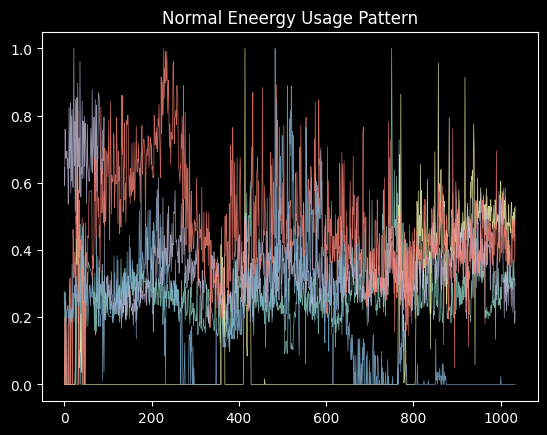

In [21]:
# Plot normal data for a customer

plt.grid()

for i in range(5):
    plt.plot(range(df_all_scaled.shape[1]-1), df_all_scaled[df_all_scaled['FLAG']==0].iloc[i,:-1], linewidth=0.5, alpha=0.8)

plt.gca().patch.set_facecolor('black') 
plt.title("Normal Eneergy Usage Pattern")
plt.grid(False)
plt.show()

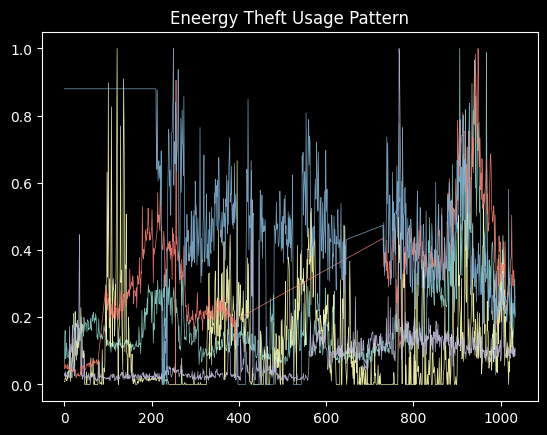

In [22]:
plt.grid()
for i in range(5):
    plt.plot(range(df_all_scaled.shape[1]-1), df_all_scaled[df_all_scaled['FLAG']==1].iloc[i,:-1], linewidth=0.5, alpha=0.9)

plt.gca().patch.set_facecolor('black') 
plt.title("Eneergy Theft Usage Pattern")
plt.grid(False)
plt.show()

In [23]:
del df, df_flag, df_theft, df_normal, df_all

In [24]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from pyts.image import GramianAngularField
from pyts.image import MarkovTransitionField
from torchvision.transforms.functional import to_pil_image
from torchvision.transforms.functional import to_tensor
from torchvision.transforms.functional import to_grayscale

gaf = GramianAngularField(method='summation', image_size=224, sample_range=(-1,1))
gas = GramianAngularField(method='difference', image_size=224, sample_range=(-1,1))
mtf = MarkovTransitionField(image_size=224, n_bins = 2)


total = len(df_all_scaled)

dataset = []

for i in tqdm(range(total)):
    df_gaf = gaf.fit_transform(df_all_scaled.iloc[i:i+1,:-1]).astype('float32')
    df_gas = gas.fit_transform(df_all_scaled.iloc[i:i+1,:-1]).astype('float32')
    df_mtf = mtf.fit_transform(df_all_scaled.iloc[i:i+1,:-1]).astype('float32')
    # image = to_pil_image(np.array(df_all_scaled.iloc[i:i+1,]).astype('float32')).resize((224, 224))    
    # gaf_tensor = torch.Tensor(df_gaf)
    # gas_tensor = torch.Tensor(df_gas)
    # mtf_tensor = torch.Tensor(df_mtf)
    # dataset.append((gaf_tensor, gas_tensor, mtf_tensor, df_all_scaled.iloc[i:i+1,-1:]))
    dataset.append((df_gaf, df_gas, df_mtf, df_all_scaled.iloc[i:i+1,-1:]))

100%|██████████| 4318/4318 [04:02<00:00, 17.83it/s]


C:\Users\kkomo\AppData\Local\Temp\ipykernel_24704\2951815641.py:8: MatplotlibDeprecationWarning: The toggle_label function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use ax.tick_params and colorbar.set_label instead.
  ax.cax.toggle_label(True)


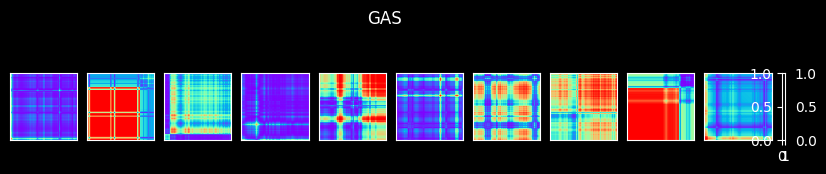

C:\Users\kkomo\AppData\Local\Temp\ipykernel_24704\2951815641.py:20: MatplotlibDeprecationWarning: The toggle_label function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use ax.tick_params and colorbar.set_label instead.
  ax.cax.toggle_label(True)


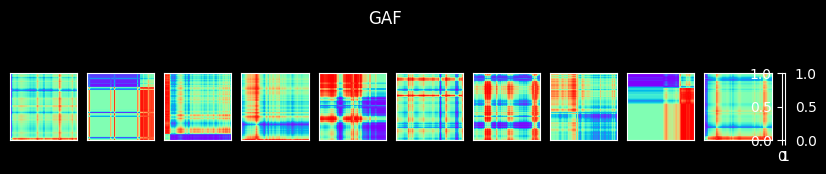

C:\Users\kkomo\AppData\Local\Temp\ipykernel_24704\2951815641.py:32: MatplotlibDeprecationWarning: The toggle_label function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use ax.tick_params and colorbar.set_label instead.
  ax.cax.toggle_label(True)


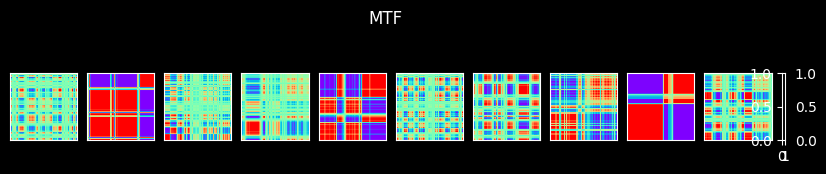

In [25]:
fig = plt.figure(figsize=(10, 2))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 10), axes_pad=0.1, cbar_mode='single', share_all=True)
for i, ax in enumerate(grid):
    im = ax.imshow(dataset[i][0][0], cmap='rainbow', origin='lower')    
grid[0].get_yaxis().set_ticks([])
grid[0].get_xaxis().set_ticks([])
# plt.colorbar(im, cax=grid.cbar_axes[0])
ax.cax.toggle_label(True)
fig.suptitle("GAS")
plt.show()


fig = plt.figure(figsize=(10, 2))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 10), axes_pad=0.1, cbar_mode='single', share_all=True)
for i, ax in enumerate(grid):
    im = ax.imshow(dataset[i][1][0], cmap='rainbow', origin='lower')    
grid[0].get_yaxis().set_ticks([])
grid[0].get_xaxis().set_ticks([])
# plt.colorbar(im, cax=grid.cbar_axes[0])
ax.cax.toggle_label(True)
fig.suptitle("GAF")
plt.show()


fig = plt.figure(figsize=(10, 2))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 10), axes_pad=0.1, cbar_mode='single', share_all=True)
for i, ax in enumerate(grid):
    im = ax.imshow(dataset[i][2][0], cmap='rainbow', origin='lower')    
grid[0].get_yaxis().set_ticks([])
grid[0].get_xaxis().set_ticks([])
# plt.colorbar(im, cax=grid.cbar_axes[0])
ax.cax.toggle_label(True)
fig.suptitle("MTF")
plt.show()


In [26]:
# split train, test dataset with 8:2 unsing normal random splitter of pytorch
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size

splitter = torch.utils.data.random_split(dataset, [train_size, test_size])
train_dataset = splitter[0]
test_dataset = splitter[1]

# split train, validation dataset with 8:2 unsing normal random splitter of pytorch
train_size = int(len(train_dataset) * 0.8)
val_size = len(train_dataset) - train_size
splitter = torch.utils.data.random_split(train_dataset, [train_size, val_size])
train_dataset = splitter[0]
val_dataset = splitter[1]

print("size (train, val, test) = ({}, {}, {})".format( len(train_dataset), len(val_dataset), len(test_dataset))) 

size (train, val, test) = (2763, 691, 864)


In [27]:
# Creating the dataset class
class EnergyData(Dataset):
    def __init__(self, datalist):
        listx = []
        listy = []
        for i in datalist:
            # listx.append(torch.cat([i[0], i[1], i[2]]))
            listx.append(np.vstack((i[0], i[1], i[2])))
            
            if i[3].values == 0:
                y = torch.tensor([1,0])
                listy.append(y.float())
                # print('yes', y)
            else:
                y = torch.tensor([0,1])
                listy.append(y.float())
                # print('else', y)
            
            # listy.append(torch.unsqueeze(torch.tensor(i[1]).float(), dim=0))           
            
        self.x = listx
        self.y = listy
        self.len = len(datalist)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return self.len


tr = EnergyData(train_dataset)
val = EnergyData(val_dataset)
ts = EnergyData(test_dataset)

del dataset

In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device)) 

torch.manual_seed(45)
torch.cuda.manual_seed_all(45)

Using cuda device


In [29]:
def print_losses(train_counter, train_losses, val_counter, val_losses, weight_decay, lr_rate):
    fig = plt.figure()
    plt.plot(train_counter, train_losses, label='Training Loss')
    plt.scatter(val_counter, val_losses, label='Validation Loss', color='red')
    plt.legend(['Training loss','Validation loss'], loc='upper right')
    plt.title('Training and Validation Loss(weight_decay = {}, lr = {})'.format(weight_decay, lr_rate))
    plt.ylabel('Cross Entropy Loss')
    fig.show()

In [30]:
def train( model, tr_data, val_data, batch_size, lr_rate, 
          moment, weight_dec, num_of_epoch, logging_period):
    
    res_loss = {}
    
    class_weights = torch.Tensor([0.5, 0.5]).to(device)

    # model =  models.vgg16(pretrained=True)
    # model.classifier[6] = nn.Sequential(
    #     nn.Linear(in_features = model.classifier[6].in_features, out_features = 2, bias = True),
    #     nn.Softmax(dim=1)
    # )

    for param in model.parameters():   
        param.requires_grad = False
    for param in model.classifier.parameters():
        param.requires_grad = True
    

    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss(weight = class_weights)
    # optimizer = optim.Adam(model.parameters(), lr=lr_rate, weight_decay=weight_dec)
    optimizer =  optim.SGD(model.parameters(), lr=lr_rate, momentum=moment, weight_decay=weight_dec)

    train_losses = []
    train_accuracy = []
    val_losses = []
    val_accuracy = []

    # List for plotting X-axis
    train_counter = []
    val_counter = []

    r_seed = 42

    trainloader = DataLoader(tr_data, batch_size=batch_size, shuffle=True)
    valloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
    
    model.train()

    for epoch in tqdm(range(num_of_epoch), total=num_of_epoch):  # loop over the dataset multiple times

        epoch_loss = 0.0
        epoch_correct = 0    
        epoch_total = 0
        running_loss = 0.0   
        running_correct = 0 
        running_total = 0

        # if epoch == 10:
        #     lr_rate = lr_rate * 0.5
        #     optimizer =  optim.SGD(model.parameters(), lr=lr_rate, momentum=moment, weight_decay=weight_dec)

        for i, data in enumerate(trainloader):  
            
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels =  data[0].to(device), data[1].to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # inputs = transform(inputs)
            outputs = model(inputs)   

            loss = criterion(outputs, labels)        
            loss.backward()
            optimizer.step()

            sum_loss = loss.item() * len(labels)
            running_loss += sum_loss
            epoch_loss += sum_loss

            num_correct = torch.eq(torch.argmax(outputs, dim=1), torch.argmax(labels, dim=1)).int().sum().item()
            running_correct += num_correct
            epoch_correct += num_correct
            # print(torch.argmax(outputs, dim=1), ' ', torch.argmax(labels, dim=1))
            # print(torch.eq(torch.argmax(outputs, dim=1), torch.argmax(labels, dim=1)))
            # print(num_correct)
            
            # print('Every batch loss: ', loss.item())
            # print('Running loss: ', running_loss)
            # print('Epoch loss: ', epoch_loss)
            # print('Every batch correct num: ', num_correct)
            # print('Running correct: ', running_correct)
            # print('Epoch correct: ', epoch_correct)

            # print('total: {}, i = {}'.format(total, i))
            
            epoch_total = epoch_total + len(labels)
            running_total = running_total + len(labels)

            # print & accumulate training statistics (loss & accuracy) every 10 iterations
            if (i % logging_period == 0):            
                avg_running_loss = running_loss / running_total
                avg_running_accuracy = 100. * running_correct / running_total

                print('Epoch{} [{}/{} ({:.0f}%)]\t   avg.loss:{:.4f}   avg.accuracy:{:.4f}'
                    .format(epoch+1, i * len(labels), len(trainloader.dataset), 100. * i / len(trainloader), 
                            avg_running_loss, avg_running_accuracy))
                
                running_loss = 0.0   
                running_correct = 0 
                running_total = 0

                train_losses.append(avg_running_loss)
                train_accuracy.append(avg_running_accuracy)
                train_counter.append((epoch)*len(trainloader.dataset)+epoch_total)    
            

        # print & accumulate val statistics (loss & accuracy)
        print('[Epoch {}] Train Loss: {:.4f} Train Accuracy: {:.4f} w_decay:{} lr_rate:{}'.format(epoch + 1, 
                            epoch_loss / epoch_total, 100. * epoch_correct / epoch_total, weight_dec, lr_rate))

        # Validation at the end of the epoch
        # set mode to eval mode & tell torch no gradients are required.
        y_true = []
        y_pred = []

        model.eval()

        with torch.no_grad():   

            val_running_loss = 0.0
            val_correct = 0
            val_count = 0            

            # loop through the data and find accuracy and loss for all val data
            for (inputs, labels) in valloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # inputs = transform(inputs)
                outputs = model(inputs) 
                
                val_correct += torch.eq(torch.argmax(outputs, dim=1), torch.argmax(labels, dim=1)).int().sum().item()
                # print('correct=', correct)

                y_true.extend(torch.argmax(labels, dim=1).cpu().numpy())  # Move labels to CPU and convert to numpy
                y_pred.extend(torch.argmax(outputs, dim=1).cpu().numpy())   # Move preds to CPU and convert to numpy

                loss = criterion(outputs, labels) 

                val_running_loss += loss.item() * len(labels)

                val_count = val_count + len(labels)      

        val_losses.append(val_running_loss / len(valloader.dataset))
        val_accuracy.append(100. * val_correct / len(valloader.dataset))
        val_counter.append((epoch+1) * len(trainloader.dataset))

        print('\nValidation set: avg.loss: {:.4f},   avg.accuracy: {}/{} ({:.4f}%)\n'.format(
        val_running_loss / len(valloader.dataset), val_correct, len(valloader.dataset), 100. * val_correct / len(valloader.dataset)))

        # Print F1 score
        rec_score = recall_score(y_true, y_pred)
        print('Recall: {:.6f}'.format(rec_score))

        pre_score = precision_score(y_true, y_pred)
        print('Precision: {:.6f}'.format(pre_score))

        f1 = f1_score(y_true, y_pred)
        print('F1 Score: {:.6f}'.format(f1))

        acc_score = accuracy_score(y_true, y_pred)
        print('Accuracy: {:.6f}'.format(acc_score))
        

        # set the model back to train mode
        model.train()

    # print('Finished Training')
    print_losses(train_counter, train_losses, val_counter, val_losses, weight_dec, lr_rate)

    res_loss[weight_dec] = val_running_loss / len(valloader.dataset)

    return f1


In [31]:
def test(model, ts, batch_size):

    y_true = []
    y_pred = []

    model.eval()

    with torch.no_grad():
        
        test_correct = 0

        testloader = DataLoader(ts, batch_size=batch_size)

        for (inputs, labels) in testloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # inputs = transform(inputs)       
            outputs = model(inputs)
            
            test_correct += torch.eq(torch.argmax(outputs, dim=1), torch.argmax(labels, dim=1)).int().sum().item()

            y_true.extend(torch.argmax(labels, dim=1).cpu().numpy())  # Move labels to CPU and convert to numpy
            y_pred.extend(torch.argmax(outputs, dim=1).cpu().numpy())   # Move preds to CPU and convert to numpy
                        
            accuracy_test = 100. * test_correct / len(testloader.dataset)

        # print('Test accuracy: {:.4f} ({}/{})'.format(accuracy_test, accuracy_test, len(testloader.dataset)))


        # plot confusion matrix
        conf_matrix = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(6,6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.show()

        # Print F1 score
        rec_score = recall_score(y_true, y_pred)
        print('Recall: {:.4f}'.format(rec_score))

        pre_score = precision_score(y_true, y_pred)
        print('Precision: {:.4f}'.format(pre_score))

        f1 = f1_score(y_true, y_pred)
        print('F1 Score: {:.4f}'.format(f1))

        acc_score = accuracy_score(y_true, y_pred)
        print('Accuracy: {:.4f}'.format(acc_score))
    
    model.train()

    return

c:\Users\kkomo\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kkomo\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


===================  Weight decay = 0.08, lr = 0.0015 ===================


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch1 [0/2763 (0%)]	   avg.loss:0.3583   avg.accuracy:50.0000
Epoch1 [256/2763 (9%)]	   avg.loss:0.3472   avg.accuracy:52.7344
Epoch1 [512/2763 (18%)]	   avg.loss:0.3586   avg.accuracy:45.7031
Epoch1 [768/2763 (28%)]	   avg.loss:0.3452   avg.accuracy:51.5625
Epoch1 [1024/2763 (37%)]	   avg.loss:0.3402   avg.accuracy:56.2500
Epoch1 [1280/2763 (46%)]	   avg.loss:0.3437   avg.accuracy:56.6406
Epoch1 [1536/2763 (55%)]	   avg.loss:0.3392   avg.accuracy:54.2969
Epoch1 [1792/2763 (64%)]	   avg.loss:0.3338   avg.accuracy:62.1094
Epoch1 [2048/2763 (74%)]	   avg.loss:0.3397   avg.accuracy:57.0312
Epoch1 [2304/2763 (83%)]	   avg.loss:0.3408   avg.accuracy:56.6406
Epoch1 [2560/2763 (92%)]	   avg.loss:0.3315   avg.accuracy:59.7656
[Epoch 1] Train Loss: 0.3420 Train Accuracy: 55.4108 w_decay:0.08 lr_rate:0.0015


  8%|▊         | 1/12 [00:20<03:41, 20.15s/it]


Validation set: avg.loss: 0.3283,   avg.accuracy: 441/691 (63.8205%)

Recall: 0.725490
Precision: 0.630170
F1 Score: 0.674479
Accuracy: 0.638205
Epoch2 [0/2763 (0%)]	   avg.loss:0.3321   avg.accuracy:53.1250
Epoch2 [256/2763 (9%)]	   avg.loss:0.3371   avg.accuracy:59.3750
Epoch2 [512/2763 (18%)]	   avg.loss:0.3331   avg.accuracy:59.3750
Epoch2 [768/2763 (28%)]	   avg.loss:0.3344   avg.accuracy:58.5938
Epoch2 [1024/2763 (37%)]	   avg.loss:0.3290   avg.accuracy:64.4531
Epoch2 [1280/2763 (46%)]	   avg.loss:0.3360   avg.accuracy:58.2031
Epoch2 [1536/2763 (55%)]	   avg.loss:0.3357   avg.accuracy:60.5469
Epoch2 [1792/2763 (64%)]	   avg.loss:0.3317   avg.accuracy:61.3281
Epoch2 [2048/2763 (74%)]	   avg.loss:0.3317   avg.accuracy:61.7188
Epoch2 [2304/2763 (83%)]	   avg.loss:0.3351   avg.accuracy:59.3750
Epoch2 [2560/2763 (92%)]	   avg.loss:0.3271   avg.accuracy:62.8906
[Epoch 2] Train Loss: 0.3327 Train Accuracy: 60.7673 w_decay:0.08 lr_rate:0.0015


 17%|█▋        | 2/12 [00:38<03:12, 19.26s/it]


Validation set: avg.loss: 0.3249,   avg.accuracy: 439/691 (63.5311%)

Recall: 0.630252
Precision: 0.652174
F1 Score: 0.641026
Accuracy: 0.635311
Epoch3 [0/2763 (0%)]	   avg.loss:0.3376   avg.accuracy:53.1250
Epoch3 [256/2763 (9%)]	   avg.loss:0.3339   avg.accuracy:57.8125
Epoch3 [512/2763 (18%)]	   avg.loss:0.3242   avg.accuracy:62.5000
Epoch3 [768/2763 (28%)]	   avg.loss:0.3255   avg.accuracy:65.2344
Epoch3 [1024/2763 (37%)]	   avg.loss:0.3298   avg.accuracy:61.7188
Epoch3 [1280/2763 (46%)]	   avg.loss:0.3237   avg.accuracy:60.9375
Epoch3 [1536/2763 (55%)]	   avg.loss:0.3251   avg.accuracy:66.7969
Epoch3 [1792/2763 (64%)]	   avg.loss:0.3287   avg.accuracy:60.5469
Epoch3 [2048/2763 (74%)]	   avg.loss:0.3355   avg.accuracy:58.5938
Epoch3 [2304/2763 (83%)]	   avg.loss:0.3251   avg.accuracy:61.7188
Epoch3 [2560/2763 (92%)]	   avg.loss:0.3212   avg.accuracy:66.7969
[Epoch 3] Train Loss: 0.3273 Train Accuracy: 61.9254 w_decay:0.08 lr_rate:0.0015


 25%|██▌       | 3/12 [00:57<02:50, 18.99s/it]


Validation set: avg.loss: 0.3236,   avg.accuracy: 440/691 (63.6758%)

Recall: 0.563025
Precision: 0.679054
F1 Score: 0.615620
Accuracy: 0.636758
Epoch4 [0/2763 (0%)]	   avg.loss:0.3133   avg.accuracy:71.8750
Epoch4 [256/2763 (9%)]	   avg.loss:0.3240   avg.accuracy:62.5000
Epoch4 [512/2763 (18%)]	   avg.loss:0.3168   avg.accuracy:67.9688
Epoch4 [768/2763 (28%)]	   avg.loss:0.3309   avg.accuracy:59.3750
Epoch4 [1024/2763 (37%)]	   avg.loss:0.3182   avg.accuracy:65.2344
Epoch4 [1280/2763 (46%)]	   avg.loss:0.3225   avg.accuracy:63.6719
Epoch4 [1536/2763 (55%)]	   avg.loss:0.3225   avg.accuracy:62.1094
Epoch4 [1792/2763 (64%)]	   avg.loss:0.3481   avg.accuracy:55.0781
Epoch4 [2048/2763 (74%)]	   avg.loss:0.3175   avg.accuracy:68.7500
Epoch4 [2304/2763 (83%)]	   avg.loss:0.3252   avg.accuracy:65.2344
Epoch4 [2560/2763 (92%)]	   avg.loss:0.3227   avg.accuracy:64.0625
[Epoch 4] Train Loss: 0.3248 Train Accuracy: 63.4093 w_decay:0.08 lr_rate:0.0015


 33%|███▎      | 4/12 [01:16<02:33, 19.13s/it]


Validation set: avg.loss: 0.3210,   avg.accuracy: 452/691 (65.4124%)

Recall: 0.635854
Precision: 0.675595
F1 Score: 0.655123
Accuracy: 0.654124
Epoch5 [0/2763 (0%)]	   avg.loss:0.3304   avg.accuracy:59.3750
Epoch5 [256/2763 (9%)]	   avg.loss:0.3325   avg.accuracy:59.7656
Epoch5 [512/2763 (18%)]	   avg.loss:0.3169   avg.accuracy:66.7969
Epoch5 [768/2763 (28%)]	   avg.loss:0.3225   avg.accuracy:64.4531
Epoch5 [1024/2763 (37%)]	   avg.loss:0.3154   avg.accuracy:67.9688
Epoch5 [1280/2763 (46%)]	   avg.loss:0.3325   avg.accuracy:58.5938
Epoch5 [1536/2763 (55%)]	   avg.loss:0.3237   avg.accuracy:62.1094
Epoch5 [1792/2763 (64%)]	   avg.loss:0.3252   avg.accuracy:60.9375
Epoch5 [2048/2763 (74%)]	   avg.loss:0.3174   avg.accuracy:69.1406
Epoch5 [2304/2763 (83%)]	   avg.loss:0.3223   avg.accuracy:66.4062
Epoch5 [2560/2763 (92%)]	   avg.loss:0.3280   avg.accuracy:62.1094
[Epoch 5] Train Loss: 0.3238 Train Accuracy: 63.7713 w_decay:0.08 lr_rate:0.0015


 42%|████▏     | 5/12 [01:36<02:14, 19.27s/it]


Validation set: avg.loss: 0.3191,   avg.accuracy: 454/691 (65.7019%)

Recall: 0.775910
Precision: 0.638249
F1 Score: 0.700379
Accuracy: 0.657019
Epoch6 [0/2763 (0%)]	   avg.loss:0.3139   avg.accuracy:68.7500
Epoch6 [256/2763 (9%)]	   avg.loss:0.3255   avg.accuracy:63.6719
Epoch6 [512/2763 (18%)]	   avg.loss:0.3270   avg.accuracy:61.3281
Epoch6 [768/2763 (28%)]	   avg.loss:0.3141   avg.accuracy:69.9219
Epoch6 [1024/2763 (37%)]	   avg.loss:0.3181   avg.accuracy:66.7969
Epoch6 [1280/2763 (46%)]	   avg.loss:0.3320   avg.accuracy:61.3281
Epoch6 [1536/2763 (55%)]	   avg.loss:0.3154   avg.accuracy:66.7969
Epoch6 [1792/2763 (64%)]	   avg.loss:0.3135   avg.accuracy:70.3125
Epoch6 [2048/2763 (74%)]	   avg.loss:0.3248   avg.accuracy:59.7656
Epoch6 [2304/2763 (83%)]	   avg.loss:0.3296   avg.accuracy:60.9375
Epoch6 [2560/2763 (92%)]	   avg.loss:0.3167   avg.accuracy:66.7969
[Epoch 6] Train Loss: 0.3216 Train Accuracy: 64.8932 w_decay:0.08 lr_rate:0.0015


 50%|█████     | 6/12 [01:55<01:55, 19.28s/it]


Validation set: avg.loss: 0.3184,   avg.accuracy: 457/691 (66.1360%)

Recall: 0.694678
Precision: 0.664879
F1 Score: 0.679452
Accuracy: 0.661360
Epoch7 [0/2763 (0%)]	   avg.loss:0.3293   avg.accuracy:53.1250
Epoch7 [256/2763 (9%)]	   avg.loss:0.3185   avg.accuracy:64.8438
Epoch7 [512/2763 (18%)]	   avg.loss:0.3241   avg.accuracy:64.0625
Epoch7 [768/2763 (28%)]	   avg.loss:0.3176   avg.accuracy:67.9688
Epoch7 [1024/2763 (37%)]	   avg.loss:0.3231   avg.accuracy:60.9375
Epoch7 [1280/2763 (46%)]	   avg.loss:0.3221   avg.accuracy:67.1875
Epoch7 [1536/2763 (55%)]	   avg.loss:0.3169   avg.accuracy:69.5312
Epoch7 [1792/2763 (64%)]	   avg.loss:0.3124   avg.accuracy:69.9219
Epoch7 [2048/2763 (74%)]	   avg.loss:0.3278   avg.accuracy:59.3750
Epoch7 [2304/2763 (83%)]	   avg.loss:0.3266   avg.accuracy:60.9375
Epoch7 [2560/2763 (92%)]	   avg.loss:0.3193   avg.accuracy:68.3594
[Epoch 7] Train Loss: 0.3205 Train Accuracy: 65.3999 w_decay:0.08 lr_rate:0.0015


 58%|█████▊    | 7/12 [02:14<01:36, 19.23s/it]


Validation set: avg.loss: 0.3192,   avg.accuracy: 457/691 (66.1360%)

Recall: 0.613445
Precision: 0.695238
F1 Score: 0.651786
Accuracy: 0.661360
Epoch8 [0/2763 (0%)]	   avg.loss:0.3273   avg.accuracy:59.3750
Epoch8 [256/2763 (9%)]	   avg.loss:0.3188   avg.accuracy:63.2812
Epoch8 [512/2763 (18%)]	   avg.loss:0.3175   avg.accuracy:66.0156
Epoch8 [768/2763 (28%)]	   avg.loss:0.3201   avg.accuracy:64.4531
Epoch8 [1024/2763 (37%)]	   avg.loss:0.3239   avg.accuracy:62.1094
Epoch8 [1280/2763 (46%)]	   avg.loss:0.3239   avg.accuracy:63.6719
Epoch8 [1536/2763 (55%)]	   avg.loss:0.3154   avg.accuracy:69.5312
Epoch8 [1792/2763 (64%)]	   avg.loss:0.3186   avg.accuracy:66.7969
Epoch8 [2048/2763 (74%)]	   avg.loss:0.3157   avg.accuracy:67.9688
Epoch8 [2304/2763 (83%)]	   avg.loss:0.3142   avg.accuracy:70.3125
Epoch8 [2560/2763 (92%)]	   avg.loss:0.3183   avg.accuracy:67.5781
[Epoch 8] Train Loss: 0.3188 Train Accuracy: 66.1238 w_decay:0.08 lr_rate:0.0015


 67%|██████▋   | 8/12 [02:33<01:16, 19.22s/it]


Validation set: avg.loss: 0.3176,   avg.accuracy: 461/691 (66.7149%)

Recall: 0.686275
Precision: 0.674931
F1 Score: 0.680556
Accuracy: 0.667149
Epoch9 [0/2763 (0%)]	   avg.loss:0.3078   avg.accuracy:75.0000
Epoch9 [256/2763 (9%)]	   avg.loss:0.3093   avg.accuracy:70.7031
Epoch9 [512/2763 (18%)]	   avg.loss:0.3343   avg.accuracy:57.0312
Epoch9 [768/2763 (28%)]	   avg.loss:0.3162   avg.accuracy:67.1875
Epoch9 [1024/2763 (37%)]	   avg.loss:0.3175   avg.accuracy:64.8438
Epoch9 [1280/2763 (46%)]	   avg.loss:0.3134   avg.accuracy:69.5312
Epoch9 [1536/2763 (55%)]	   avg.loss:0.3195   avg.accuracy:67.9688
Epoch9 [1792/2763 (64%)]	   avg.loss:0.3164   avg.accuracy:67.5781
Epoch9 [2048/2763 (74%)]	   avg.loss:0.3240   avg.accuracy:61.3281
Epoch9 [2304/2763 (83%)]	   avg.loss:0.3088   avg.accuracy:72.6562
Epoch9 [2560/2763 (92%)]	   avg.loss:0.3200   avg.accuracy:66.4062
[Epoch 9] Train Loss: 0.3180 Train Accuracy: 66.4133 w_decay:0.08 lr_rate:0.0015


 75%|███████▌  | 9/12 [02:52<00:57, 19.17s/it]


Validation set: avg.loss: 0.3174,   avg.accuracy: 463/691 (67.0043%)

Recall: 0.689076
Precision: 0.677686
F1 Score: 0.683333
Accuracy: 0.670043
Epoch10 [0/2763 (0%)]	   avg.loss:0.3025   avg.accuracy:78.1250
Epoch10 [256/2763 (9%)]	   avg.loss:0.3198   avg.accuracy:66.0156
Epoch10 [512/2763 (18%)]	   avg.loss:0.3161   avg.accuracy:67.9688
Epoch10 [768/2763 (28%)]	   avg.loss:0.3125   avg.accuracy:70.7031
Epoch10 [1024/2763 (37%)]	   avg.loss:0.3154   avg.accuracy:67.1875
Epoch10 [1280/2763 (46%)]	   avg.loss:0.3136   avg.accuracy:68.3594
Epoch10 [1536/2763 (55%)]	   avg.loss:0.3225   avg.accuracy:66.0156
Epoch10 [1792/2763 (64%)]	   avg.loss:0.3290   avg.accuracy:60.1562
Epoch10 [2048/2763 (74%)]	   avg.loss:0.3033   avg.accuracy:70.7031
Epoch10 [2304/2763 (83%)]	   avg.loss:0.3213   avg.accuracy:62.1094
Epoch10 [2560/2763 (92%)]	   avg.loss:0.3198   avg.accuracy:66.4062
[Epoch 10] Train Loss: 0.3174 Train Accuracy: 66.3771 w_decay:0.08 lr_rate:0.0015


 83%|████████▎ | 10/12 [03:12<00:38, 19.13s/it]


Validation set: avg.loss: 0.3179,   avg.accuracy: 463/691 (67.0043%)

Recall: 0.647059
Precision: 0.693694
F1 Score: 0.669565
Accuracy: 0.670043
Epoch11 [0/2763 (0%)]	   avg.loss:0.3171   avg.accuracy:75.0000
Epoch11 [256/2763 (9%)]	   avg.loss:0.3211   avg.accuracy:66.0156
Epoch11 [512/2763 (18%)]	   avg.loss:0.3088   avg.accuracy:72.2656
Epoch11 [768/2763 (28%)]	   avg.loss:0.3161   avg.accuracy:67.1875
Epoch11 [1024/2763 (37%)]	   avg.loss:0.3234   avg.accuracy:61.7188
Epoch11 [1280/2763 (46%)]	   avg.loss:0.3139   avg.accuracy:69.5312
Epoch11 [1536/2763 (55%)]	   avg.loss:0.3069   avg.accuracy:72.6562
Epoch11 [1792/2763 (64%)]	   avg.loss:0.3118   avg.accuracy:68.7500
Epoch11 [2048/2763 (74%)]	   avg.loss:0.3218   avg.accuracy:61.7188
Epoch11 [2304/2763 (83%)]	   avg.loss:0.3174   avg.accuracy:64.4531
Epoch11 [2560/2763 (92%)]	   avg.loss:0.3229   avg.accuracy:64.4531
[Epoch 11] Train Loss: 0.3166 Train Accuracy: 66.9924 w_decay:0.08 lr_rate:0.0015


 92%|█████████▏| 11/12 [03:31<00:19, 19.10s/it]


Validation set: avg.loss: 0.3175,   avg.accuracy: 465/691 (67.2938%)

Recall: 0.714286
Precision: 0.672823
F1 Score: 0.692935
Accuracy: 0.672938
Epoch12 [0/2763 (0%)]	   avg.loss:0.2888   avg.accuracy:87.5000
Epoch12 [256/2763 (9%)]	   avg.loss:0.3171   avg.accuracy:67.9688
Epoch12 [512/2763 (18%)]	   avg.loss:0.3191   avg.accuracy:67.9688
Epoch12 [768/2763 (28%)]	   avg.loss:0.3123   avg.accuracy:70.3125
Epoch12 [1024/2763 (37%)]	   avg.loss:0.3159   avg.accuracy:65.6250
Epoch12 [1280/2763 (46%)]	   avg.loss:0.3158   avg.accuracy:66.4062
Epoch12 [1536/2763 (55%)]	   avg.loss:0.3151   avg.accuracy:66.4062
Epoch12 [1792/2763 (64%)]	   avg.loss:0.3184   avg.accuracy:66.4062
Epoch12 [2048/2763 (74%)]	   avg.loss:0.3171   avg.accuracy:67.9688
Epoch12 [2304/2763 (83%)]	   avg.loss:0.3188   avg.accuracy:64.4531
Epoch12 [2560/2763 (92%)]	   avg.loss:0.3175   avg.accuracy:67.1875
[Epoch 12] Train Loss: 0.3163 Train Accuracy: 67.3543 w_decay:0.08 lr_rate:0.0015


100%|██████████| 12/12 [03:50<00:00, 19.19s/it]


Validation set: avg.loss: 0.3179,   avg.accuracy: 466/691 (67.4385%)

Recall: 0.652661
Precision: 0.697605
F1 Score: 0.674385
Accuracy: 0.674385



C:\Users\kkomo\AppData\Local\Temp\ipykernel_24704\3978523012.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
c:\Users\kkomo\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kkomo\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


===================  Weight decay = 0.09, lr = 0.0015 ===================


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch1 [0/2763 (0%)]	   avg.loss:0.3410   avg.accuracy:59.3750
Epoch1 [256/2763 (9%)]	   avg.loss:0.3531   avg.accuracy:49.2188
Epoch1 [512/2763 (18%)]	   avg.loss:0.3499   avg.accuracy:49.2188
Epoch1 [768/2763 (28%)]	   avg.loss:0.3404   avg.accuracy:55.8594
Epoch1 [1024/2763 (37%)]	   avg.loss:0.3432   avg.accuracy:55.0781
Epoch1 [1280/2763 (46%)]	   avg.loss:0.3360   avg.accuracy:58.2031
Epoch1 [1536/2763 (55%)]	   avg.loss:0.3426   avg.accuracy:53.1250
Epoch1 [1792/2763 (64%)]	   avg.loss:0.3380   avg.accuracy:58.5938
Epoch1 [2048/2763 (74%)]	   avg.loss:0.3372   avg.accuracy:60.9375
Epoch1 [2304/2763 (83%)]	   avg.loss:0.3368   avg.accuracy:59.7656
Epoch1 [2560/2763 (92%)]	   avg.loss:0.3348   avg.accuracy:61.3281
[Epoch 1] Train Loss: 0.3409 Train Accuracy: 56.2794 w_decay:0.09 lr_rate:0.0015


  8%|▊         | 1/12 [00:19<03:29, 19.06s/it]


Validation set: avg.loss: 0.3287,   avg.accuracy: 438/691 (63.3864%)

Recall: 0.742297
Precision: 0.622066
F1 Score: 0.676884
Accuracy: 0.633864
Epoch2 [0/2763 (0%)]	   avg.loss:0.3426   avg.accuracy:59.3750
Epoch2 [256/2763 (9%)]	   avg.loss:0.3349   avg.accuracy:61.3281
Epoch2 [512/2763 (18%)]	   avg.loss:0.3300   avg.accuracy:60.9375
Epoch2 [768/2763 (28%)]	   avg.loss:0.3350   avg.accuracy:57.4219
Epoch2 [1024/2763 (37%)]	   avg.loss:0.3364   avg.accuracy:57.8125
Epoch2 [1280/2763 (46%)]	   avg.loss:0.3324   avg.accuracy:59.7656
Epoch2 [1536/2763 (55%)]	   avg.loss:0.3320   avg.accuracy:58.2031
Epoch2 [1792/2763 (64%)]	   avg.loss:0.3298   avg.accuracy:60.9375
Epoch2 [2048/2763 (74%)]	   avg.loss:0.3260   avg.accuracy:65.2344
Epoch2 [2304/2763 (83%)]	   avg.loss:0.3326   avg.accuracy:60.1562
Epoch2 [2560/2763 (92%)]	   avg.loss:0.3293   avg.accuracy:60.9375
[Epoch 2] Train Loss: 0.3324 Train Accuracy: 60.1158 w_decay:0.09 lr_rate:0.0015


 17%|█▋        | 2/12 [00:38<03:10, 19.04s/it]


Validation set: avg.loss: 0.3246,   avg.accuracy: 444/691 (64.2547%)

Recall: 0.672269
Precision: 0.648649
F1 Score: 0.660248
Accuracy: 0.642547
Epoch3 [0/2763 (0%)]	   avg.loss:0.3299   avg.accuracy:56.2500
Epoch3 [256/2763 (9%)]	   avg.loss:0.3253   avg.accuracy:59.3750
Epoch3 [512/2763 (18%)]	   avg.loss:0.3187   avg.accuracy:66.7969
Epoch3 [768/2763 (28%)]	   avg.loss:0.3219   avg.accuracy:62.8906
Epoch3 [1024/2763 (37%)]	   avg.loss:0.3302   avg.accuracy:63.6719
Epoch3 [1280/2763 (46%)]	   avg.loss:0.3263   avg.accuracy:63.2812
Epoch3 [1536/2763 (55%)]	   avg.loss:0.3389   avg.accuracy:54.6875
Epoch3 [1792/2763 (64%)]	   avg.loss:0.3295   avg.accuracy:61.3281
Epoch3 [2048/2763 (74%)]	   avg.loss:0.3328   avg.accuracy:60.1562
Epoch3 [2304/2763 (83%)]	   avg.loss:0.3302   avg.accuracy:61.7188
Epoch3 [2560/2763 (92%)]	   avg.loss:0.3297   avg.accuracy:60.5469
[Epoch 3] Train Loss: 0.3280 Train Accuracy: 61.3102 w_decay:0.09 lr_rate:0.0015


 25%|██▌       | 3/12 [00:57<02:51, 19.04s/it]


Validation set: avg.loss: 0.3264,   avg.accuracy: 426/691 (61.6498%)

Recall: 0.490196
Precision: 0.678295
F1 Score: 0.569106
Accuracy: 0.616498
Epoch4 [0/2763 (0%)]	   avg.loss:0.3618   avg.accuracy:46.8750
Epoch4 [256/2763 (9%)]	   avg.loss:0.3320   avg.accuracy:58.9844
Epoch4 [512/2763 (18%)]	   avg.loss:0.3186   avg.accuracy:68.3594
Epoch4 [768/2763 (28%)]	   avg.loss:0.3220   avg.accuracy:68.3594
Epoch4 [1024/2763 (37%)]	   avg.loss:0.3290   avg.accuracy:62.1094
Epoch4 [1280/2763 (46%)]	   avg.loss:0.3170   avg.accuracy:67.9688
Epoch4 [1536/2763 (55%)]	   avg.loss:0.3209   avg.accuracy:64.8438
Epoch4 [1792/2763 (64%)]	   avg.loss:0.3303   avg.accuracy:63.6719
Epoch4 [2048/2763 (74%)]	   avg.loss:0.3360   avg.accuracy:55.4688
Epoch4 [2304/2763 (83%)]	   avg.loss:0.3212   avg.accuracy:63.2812
Epoch4 [2560/2763 (92%)]	   avg.loss:0.3239   avg.accuracy:63.2812
[Epoch 4] Train Loss: 0.3261 Train Accuracy: 63.0474 w_decay:0.09 lr_rate:0.0015


 33%|███▎      | 4/12 [01:16<02:32, 19.12s/it]


Validation set: avg.loss: 0.3215,   avg.accuracy: 446/691 (64.5441%)

Recall: 0.700280
Precision: 0.644330
F1 Score: 0.671141
Accuracy: 0.645441
Epoch5 [0/2763 (0%)]	   avg.loss:0.3288   avg.accuracy:65.6250
Epoch5 [256/2763 (9%)]	   avg.loss:0.3233   avg.accuracy:65.6250
Epoch5 [512/2763 (18%)]	   avg.loss:0.3314   avg.accuracy:59.7656
Epoch5 [768/2763 (28%)]	   avg.loss:0.3266   avg.accuracy:63.6719
Epoch5 [1024/2763 (37%)]	   avg.loss:0.3276   avg.accuracy:62.1094
Epoch5 [1280/2763 (46%)]	   avg.loss:0.3300   avg.accuracy:62.8906
Epoch5 [1536/2763 (55%)]	   avg.loss:0.3263   avg.accuracy:62.5000
Epoch5 [1792/2763 (64%)]	   avg.loss:0.3253   avg.accuracy:63.2812
Epoch5 [2048/2763 (74%)]	   avg.loss:0.3278   avg.accuracy:64.0625
Epoch5 [2304/2763 (83%)]	   avg.loss:0.3216   avg.accuracy:66.4062
Epoch5 [2560/2763 (92%)]	   avg.loss:0.3294   avg.accuracy:63.2812
[Epoch 5] Train Loss: 0.3264 Train Accuracy: 63.5541 w_decay:0.09 lr_rate:0.0015


 42%|████▏     | 5/12 [01:35<02:13, 19.09s/it]


Validation set: avg.loss: 0.3215,   avg.accuracy: 451/691 (65.2677%)

Recall: 0.686275
Precision: 0.656836
F1 Score: 0.671233
Accuracy: 0.652677
Epoch6 [0/2763 (0%)]	   avg.loss:0.3318   avg.accuracy:56.2500
Epoch6 [256/2763 (9%)]	   avg.loss:0.3265   avg.accuracy:62.8906
Epoch6 [512/2763 (18%)]	   avg.loss:0.3219   avg.accuracy:66.4062
Epoch6 [768/2763 (28%)]	   avg.loss:0.3239   avg.accuracy:63.2812
Epoch6 [1024/2763 (37%)]	   avg.loss:0.3252   avg.accuracy:64.4531
Epoch6 [1280/2763 (46%)]	   avg.loss:0.3272   avg.accuracy:64.8438
Epoch6 [1536/2763 (55%)]	   avg.loss:0.3215   avg.accuracy:69.9219
Epoch6 [1792/2763 (64%)]	   avg.loss:0.3285   avg.accuracy:61.7188
Epoch6 [2048/2763 (74%)]	   avg.loss:0.3162   avg.accuracy:67.5781
Epoch6 [2304/2763 (83%)]	   avg.loss:0.3254   avg.accuracy:65.2344
Epoch6 [2560/2763 (92%)]	   avg.loss:0.3237   avg.accuracy:64.0625
[Epoch 6] Train Loss: 0.3240 Train Accuracy: 65.0742 w_decay:0.09 lr_rate:0.0015


 50%|█████     | 6/12 [01:54<01:54, 19.08s/it]


Validation set: avg.loss: 0.3241,   avg.accuracy: 431/691 (62.3734%)

Recall: 0.495798
Precision: 0.688716
F1 Score: 0.576547
Accuracy: 0.623734
Epoch7 [0/2763 (0%)]	   avg.loss:0.3203   avg.accuracy:65.6250
Epoch7 [256/2763 (9%)]	   avg.loss:0.3239   avg.accuracy:63.2812
Epoch7 [512/2763 (18%)]	   avg.loss:0.3214   avg.accuracy:64.0625
Epoch7 [768/2763 (28%)]	   avg.loss:0.3273   avg.accuracy:63.2812
Epoch7 [1024/2763 (37%)]	   avg.loss:0.3254   avg.accuracy:66.0156
Epoch7 [1280/2763 (46%)]	   avg.loss:0.3302   avg.accuracy:60.5469
Epoch7 [1536/2763 (55%)]	   avg.loss:0.3197   avg.accuracy:64.4531
Epoch7 [1792/2763 (64%)]	   avg.loss:0.3265   avg.accuracy:59.3750
Epoch7 [2048/2763 (74%)]	   avg.loss:0.3242   avg.accuracy:66.7969
Epoch7 [2304/2763 (83%)]	   avg.loss:0.3162   avg.accuracy:67.5781
Epoch7 [2560/2763 (92%)]	   avg.loss:0.3208   avg.accuracy:66.4062
[Epoch 7] Train Loss: 0.3232 Train Accuracy: 64.4951 w_decay:0.09 lr_rate:0.0015


 58%|█████▊    | 7/12 [02:13<01:35, 19.05s/it]


Validation set: avg.loss: 0.3204,   avg.accuracy: 459/691 (66.4255%)

Recall: 0.719888
Precision: 0.660668
F1 Score: 0.689008
Accuracy: 0.664255
Epoch8 [0/2763 (0%)]	   avg.loss:0.3458   avg.accuracy:59.3750
Epoch8 [256/2763 (9%)]	   avg.loss:0.3328   avg.accuracy:62.8906
Epoch8 [512/2763 (18%)]	   avg.loss:0.3259   avg.accuracy:65.2344
Epoch8 [768/2763 (28%)]	   avg.loss:0.3175   avg.accuracy:69.5312
Epoch8 [1024/2763 (37%)]	   avg.loss:0.3189   avg.accuracy:63.2812
Epoch8 [1280/2763 (46%)]	   avg.loss:0.3199   avg.accuracy:68.3594
Epoch8 [1536/2763 (55%)]	   avg.loss:0.3163   avg.accuracy:67.9688
Epoch8 [1792/2763 (64%)]	   avg.loss:0.3236   avg.accuracy:60.5469
Epoch8 [2048/2763 (74%)]	   avg.loss:0.3229   avg.accuracy:64.8438
Epoch8 [2304/2763 (83%)]	   avg.loss:0.3207   avg.accuracy:66.0156
Epoch8 [2560/2763 (92%)]	   avg.loss:0.3185   avg.accuracy:68.7500
[Epoch 8] Train Loss: 0.3221 Train Accuracy: 65.5085 w_decay:0.09 lr_rate:0.0015


 67%|██████▋   | 8/12 [02:32<01:16, 19.05s/it]


Validation set: avg.loss: 0.3200,   avg.accuracy: 464/691 (67.1491%)

Recall: 0.711485
Precision: 0.671958
F1 Score: 0.691156
Accuracy: 0.671491
Epoch9 [0/2763 (0%)]	   avg.loss:0.3275   avg.accuracy:56.2500
Epoch9 [256/2763 (9%)]	   avg.loss:0.3181   avg.accuracy:67.5781
Epoch9 [512/2763 (18%)]	   avg.loss:0.3258   avg.accuracy:68.7500
Epoch9 [768/2763 (28%)]	   avg.loss:0.3144   avg.accuracy:69.9219
Epoch9 [1024/2763 (37%)]	   avg.loss:0.3219   avg.accuracy:64.4531
Epoch9 [1280/2763 (46%)]	   avg.loss:0.3163   avg.accuracy:69.5312
Epoch9 [1536/2763 (55%)]	   avg.loss:0.3204   avg.accuracy:64.8438
Epoch9 [1792/2763 (64%)]	   avg.loss:0.3287   avg.accuracy:62.1094
Epoch9 [2048/2763 (74%)]	   avg.loss:0.3166   avg.accuracy:69.9219
Epoch9 [2304/2763 (83%)]	   avg.loss:0.3234   avg.accuracy:60.9375
Epoch9 [2560/2763 (92%)]	   avg.loss:0.3249   avg.accuracy:61.7188
[Epoch 9] Train Loss: 0.3213 Train Accuracy: 65.6533 w_decay:0.09 lr_rate:0.0015


 75%|███████▌  | 9/12 [02:51<00:57, 19.10s/it]


Validation set: avg.loss: 0.3205,   avg.accuracy: 459/691 (66.4255%)

Recall: 0.652661
Precision: 0.683284
F1 Score: 0.667622
Accuracy: 0.664255
Epoch10 [0/2763 (0%)]	   avg.loss:0.3121   avg.accuracy:68.7500
Epoch10 [256/2763 (9%)]	   avg.loss:0.3231   avg.accuracy:64.4531
Epoch10 [512/2763 (18%)]	   avg.loss:0.3259   avg.accuracy:60.5469
Epoch10 [768/2763 (28%)]	   avg.loss:0.3169   avg.accuracy:67.9688
Epoch10 [1024/2763 (37%)]	   avg.loss:0.3200   avg.accuracy:67.9688
Epoch10 [1280/2763 (46%)]	   avg.loss:0.3173   avg.accuracy:71.4844
Epoch10 [1536/2763 (55%)]	   avg.loss:0.3136   avg.accuracy:68.3594
Epoch10 [1792/2763 (64%)]	   avg.loss:0.3242   avg.accuracy:63.6719
Epoch10 [2048/2763 (74%)]	   avg.loss:0.3174   avg.accuracy:64.0625
Epoch10 [2304/2763 (83%)]	   avg.loss:0.3245   avg.accuracy:65.2344
Epoch10 [2560/2763 (92%)]	   avg.loss:0.3198   avg.accuracy:66.7969
[Epoch 10] Train Loss: 0.3208 Train Accuracy: 65.8342 w_decay:0.09 lr_rate:0.0015


 83%|████████▎ | 10/12 [03:10<00:38, 19.08s/it]


Validation set: avg.loss: 0.3203,   avg.accuracy: 462/691 (66.8596%)

Recall: 0.677871
Precision: 0.679775
F1 Score: 0.678822
Accuracy: 0.668596
Epoch11 [0/2763 (0%)]	   avg.loss:0.3310   avg.accuracy:56.2500
Epoch11 [256/2763 (9%)]	   avg.loss:0.3260   avg.accuracy:65.6250
Epoch11 [512/2763 (18%)]	   avg.loss:0.3164   avg.accuracy:65.6250
Epoch11 [768/2763 (28%)]	   avg.loss:0.3177   avg.accuracy:68.3594
Epoch11 [1024/2763 (37%)]	   avg.loss:0.3233   avg.accuracy:66.0156
Epoch11 [1280/2763 (46%)]	   avg.loss:0.3148   avg.accuracy:69.1406
Epoch11 [1536/2763 (55%)]	   avg.loss:0.3189   avg.accuracy:67.1875
Epoch11 [1792/2763 (64%)]	   avg.loss:0.3164   avg.accuracy:66.0156
Epoch11 [2048/2763 (74%)]	   avg.loss:0.3242   avg.accuracy:61.7188
Epoch11 [2304/2763 (83%)]	   avg.loss:0.3137   avg.accuracy:70.7031
Epoch11 [2560/2763 (92%)]	   avg.loss:0.3187   avg.accuracy:67.1875
[Epoch 11] Train Loss: 0.3200 Train Accuracy: 66.2685 w_decay:0.09 lr_rate:0.0015


 92%|█████████▏| 11/12 [03:29<00:19, 19.12s/it]


Validation set: avg.loss: 0.3203,   avg.accuracy: 459/691 (66.4255%)

Recall: 0.750700
Precision: 0.652068
F1 Score: 0.697917
Accuracy: 0.664255
Epoch12 [0/2763 (0%)]	   avg.loss:0.3133   avg.accuracy:71.8750
Epoch12 [256/2763 (9%)]	   avg.loss:0.3206   avg.accuracy:65.6250
Epoch12 [512/2763 (18%)]	   avg.loss:0.3206   avg.accuracy:67.1875
Epoch12 [768/2763 (28%)]	   avg.loss:0.3196   avg.accuracy:66.7969
Epoch12 [1024/2763 (37%)]	   avg.loss:0.3243   avg.accuracy:65.2344
Epoch12 [1280/2763 (46%)]	   avg.loss:0.3192   avg.accuracy:67.1875
Epoch12 [1536/2763 (55%)]	   avg.loss:0.3184   avg.accuracy:67.1875
Epoch12 [1792/2763 (64%)]	   avg.loss:0.3159   avg.accuracy:67.9688
Epoch12 [2048/2763 (74%)]	   avg.loss:0.3177   avg.accuracy:67.9688
Epoch12 [2304/2763 (83%)]	   avg.loss:0.3261   avg.accuracy:66.4062
Epoch12 [2560/2763 (92%)]	   avg.loss:0.3222   avg.accuracy:67.5781
[Epoch 12] Train Loss: 0.3205 Train Accuracy: 66.7391 w_decay:0.09 lr_rate:0.0015


100%|██████████| 12/12 [03:49<00:00, 19.10s/it]


Validation set: avg.loss: 0.3205,   avg.accuracy: 463/691 (67.0043%)

Recall: 0.711485
Precision: 0.670185
F1 Score: 0.690217
Accuracy: 0.670043



C:\Users\kkomo\AppData\Local\Temp\ipykernel_24704\3978523012.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
c:\Users\kkomo\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kkomo\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


===================  Weight decay = 0.1, lr = 0.0015 ===================


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch1 [0/2763 (0%)]	   avg.loss:0.3419   avg.accuracy:53.1250
Epoch1 [256/2763 (9%)]	   avg.loss:0.3434   avg.accuracy:55.0781
Epoch1 [512/2763 (18%)]	   avg.loss:0.3370   avg.accuracy:58.9844
Epoch1 [768/2763 (28%)]	   avg.loss:0.3455   avg.accuracy:55.8594
Epoch1 [1024/2763 (37%)]	   avg.loss:0.3565   avg.accuracy:50.7812
Epoch1 [1280/2763 (46%)]	   avg.loss:0.3508   avg.accuracy:51.5625
Epoch1 [1536/2763 (55%)]	   avg.loss:0.3389   avg.accuracy:55.4688
Epoch1 [1792/2763 (64%)]	   avg.loss:0.3444   avg.accuracy:54.2969
Epoch1 [2048/2763 (74%)]	   avg.loss:0.3467   avg.accuracy:50.3906
Epoch1 [2304/2763 (83%)]	   avg.loss:0.3483   avg.accuracy:49.6094
Epoch1 [2560/2763 (92%)]	   avg.loss:0.3308   avg.accuracy:57.8125
[Epoch 1] Train Loss: 0.3438 Train Accuracy: 54.4336 w_decay:0.1 lr_rate:0.0015


  8%|▊         | 1/12 [00:19<03:30, 19.10s/it]


Validation set: avg.loss: 0.3288,   avg.accuracy: 436/691 (63.0970%)

Recall: 0.669468
Precision: 0.635638
F1 Score: 0.652115
Accuracy: 0.630970
Epoch2 [0/2763 (0%)]	   avg.loss:0.3279   avg.accuracy:59.3750
Epoch2 [256/2763 (9%)]	   avg.loss:0.3313   avg.accuracy:64.0625
Epoch2 [512/2763 (18%)]	   avg.loss:0.3454   avg.accuracy:55.0781
Epoch2 [768/2763 (28%)]	   avg.loss:0.3310   avg.accuracy:62.1094
Epoch2 [1024/2763 (37%)]	   avg.loss:0.3363   avg.accuracy:57.8125
Epoch2 [1280/2763 (46%)]	   avg.loss:0.3390   avg.accuracy:57.0312
Epoch2 [1536/2763 (55%)]	   avg.loss:0.3351   avg.accuracy:57.8125
Epoch2 [1792/2763 (64%)]	   avg.loss:0.3293   avg.accuracy:66.0156
Epoch2 [2048/2763 (74%)]	   avg.loss:0.3223   avg.accuracy:69.5312
Epoch2 [2304/2763 (83%)]	   avg.loss:0.3342   avg.accuracy:60.5469
Epoch2 [2560/2763 (92%)]	   avg.loss:0.3261   avg.accuracy:63.2812
[Epoch 2] Train Loss: 0.3326 Train Accuracy: 61.4187 w_decay:0.1 lr_rate:0.0015


 17%|█▋        | 2/12 [00:38<03:11, 19.11s/it]


Validation set: avg.loss: 0.3268,   avg.accuracy: 432/691 (62.5181%)

Recall: 0.596639
Precision: 0.649390
F1 Score: 0.621898
Accuracy: 0.625181
Epoch3 [0/2763 (0%)]	   avg.loss:0.3049   avg.accuracy:81.2500
Epoch3 [256/2763 (9%)]	   avg.loss:0.3390   avg.accuracy:58.5938
Epoch3 [512/2763 (18%)]	   avg.loss:0.3232   avg.accuracy:64.8438
Epoch3 [768/2763 (28%)]	   avg.loss:0.3312   avg.accuracy:62.1094
Epoch3 [1024/2763 (37%)]	   avg.loss:0.3232   avg.accuracy:64.4531
Epoch3 [1280/2763 (46%)]	   avg.loss:0.3271   avg.accuracy:63.2812
Epoch3 [1536/2763 (55%)]	   avg.loss:0.3349   avg.accuracy:58.5938
Epoch3 [1792/2763 (64%)]	   avg.loss:0.3267   avg.accuracy:61.7188
Epoch3 [2048/2763 (74%)]	   avg.loss:0.3280   avg.accuracy:63.6719
Epoch3 [2304/2763 (83%)]	   avg.loss:0.3290   avg.accuracy:61.7188
Epoch3 [2560/2763 (92%)]	   avg.loss:0.3331   avg.accuracy:60.5469
[Epoch 3] Train Loss: 0.3297 Train Accuracy: 61.8531 w_decay:0.1 lr_rate:0.0015


 25%|██▌       | 3/12 [00:57<02:52, 19.12s/it]


Validation set: avg.loss: 0.3239,   avg.accuracy: 445/691 (64.3994%)

Recall: 0.756303
Precision: 0.629371
F1 Score: 0.687023
Accuracy: 0.643994
Epoch4 [0/2763 (0%)]	   avg.loss:0.3209   avg.accuracy:62.5000
Epoch4 [256/2763 (9%)]	   avg.loss:0.3250   avg.accuracy:64.4531
Epoch4 [512/2763 (18%)]	   avg.loss:0.3313   avg.accuracy:63.2812
Epoch4 [768/2763 (28%)]	   avg.loss:0.3216   avg.accuracy:66.4062
Epoch4 [1024/2763 (37%)]	   avg.loss:0.3256   avg.accuracy:63.6719
Epoch4 [1280/2763 (46%)]	   avg.loss:0.3272   avg.accuracy:61.3281
Epoch4 [1536/2763 (55%)]	   avg.loss:0.3181   avg.accuracy:64.4531
Epoch4 [1792/2763 (64%)]	   avg.loss:0.3366   avg.accuracy:55.8594
Epoch4 [2048/2763 (74%)]	   avg.loss:0.3297   avg.accuracy:62.8906
Epoch4 [2304/2763 (83%)]	   avg.loss:0.3316   avg.accuracy:61.7188
Epoch4 [2560/2763 (92%)]	   avg.loss:0.3265   avg.accuracy:62.8906
[Epoch 4] Train Loss: 0.3272 Train Accuracy: 62.4321 w_decay:0.1 lr_rate:0.0015


 33%|███▎      | 4/12 [01:16<02:32, 19.08s/it]


Validation set: avg.loss: 0.3233,   avg.accuracy: 449/691 (64.9783%)

Recall: 0.750700
Precision: 0.636580
F1 Score: 0.688946
Accuracy: 0.649783
Epoch5 [0/2763 (0%)]	   avg.loss:0.3355   avg.accuracy:53.1250
Epoch5 [256/2763 (9%)]	   avg.loss:0.3298   avg.accuracy:63.2812
Epoch5 [512/2763 (18%)]	   avg.loss:0.3286   avg.accuracy:59.7656
Epoch5 [768/2763 (28%)]	   avg.loss:0.3284   avg.accuracy:62.8906
Epoch5 [1024/2763 (37%)]	   avg.loss:0.3329   avg.accuracy:60.5469
Epoch5 [1280/2763 (46%)]	   avg.loss:0.3236   avg.accuracy:68.3594
Epoch5 [1536/2763 (55%)]	   avg.loss:0.3264   avg.accuracy:64.8438
Epoch5 [1792/2763 (64%)]	   avg.loss:0.3209   avg.accuracy:64.0625
Epoch5 [2048/2763 (74%)]	   avg.loss:0.3229   avg.accuracy:67.1875
Epoch5 [2304/2763 (83%)]	   avg.loss:0.3230   avg.accuracy:66.0156
Epoch5 [2560/2763 (92%)]	   avg.loss:0.3319   avg.accuracy:59.7656
[Epoch 5] Train Loss: 0.3270 Train Accuracy: 63.3731 w_decay:0.1 lr_rate:0.0015


 42%|████▏     | 5/12 [01:35<02:13, 19.06s/it]


Validation set: avg.loss: 0.3227,   avg.accuracy: 456/691 (65.9913%)

Recall: 0.745098
Precision: 0.648780
F1 Score: 0.693611
Accuracy: 0.659913
Epoch6 [0/2763 (0%)]	   avg.loss:0.3259   avg.accuracy:65.6250
Epoch6 [256/2763 (9%)]	   avg.loss:0.3304   avg.accuracy:62.1094
Epoch6 [512/2763 (18%)]	   avg.loss:0.3274   avg.accuracy:66.0156
Epoch6 [768/2763 (28%)]	   avg.loss:0.3245   avg.accuracy:62.8906
Epoch6 [1024/2763 (37%)]	   avg.loss:0.3229   avg.accuracy:66.0156
Epoch6 [1280/2763 (46%)]	   avg.loss:0.3282   avg.accuracy:60.1562
Epoch6 [1536/2763 (55%)]	   avg.loss:0.3290   avg.accuracy:60.9375
Epoch6 [1792/2763 (64%)]	   avg.loss:0.3262   avg.accuracy:64.0625
Epoch6 [2048/2763 (74%)]	   avg.loss:0.3214   avg.accuracy:66.4062
Epoch6 [2304/2763 (83%)]	   avg.loss:0.3214   avg.accuracy:67.1875
Epoch6 [2560/2763 (92%)]	   avg.loss:0.3286   avg.accuracy:61.7188
[Epoch 6] Train Loss: 0.3256 Train Accuracy: 63.8075 w_decay:0.1 lr_rate:0.0015


 50%|█████     | 6/12 [01:54<01:54, 19.08s/it]


Validation set: avg.loss: 0.3225,   avg.accuracy: 456/691 (65.9913%)

Recall: 0.728291
Precision: 0.653266
F1 Score: 0.688742
Accuracy: 0.659913
Epoch7 [0/2763 (0%)]	   avg.loss:0.3310   avg.accuracy:68.7500
Epoch7 [256/2763 (9%)]	   avg.loss:0.3292   avg.accuracy:62.1094
Epoch7 [512/2763 (18%)]	   avg.loss:0.3204   avg.accuracy:67.5781
Epoch7 [768/2763 (28%)]	   avg.loss:0.3217   avg.accuracy:67.5781
Epoch7 [1024/2763 (37%)]	   avg.loss:0.3215   avg.accuracy:66.7969
Epoch7 [1280/2763 (46%)]	   avg.loss:0.3234   avg.accuracy:66.0156
Epoch7 [1536/2763 (55%)]	   avg.loss:0.3264   avg.accuracy:65.2344
Epoch7 [1792/2763 (64%)]	   avg.loss:0.3313   avg.accuracy:62.8906
Epoch7 [2048/2763 (74%)]	   avg.loss:0.3257   avg.accuracy:63.2812
Epoch7 [2304/2763 (83%)]	   avg.loss:0.3206   avg.accuracy:65.6250
Epoch7 [2560/2763 (92%)]	   avg.loss:0.3207   avg.accuracy:69.5312
[Epoch 7] Train Loss: 0.3243 Train Accuracy: 65.6895 w_decay:0.1 lr_rate:0.0015


 58%|█████▊    | 7/12 [02:13<01:35, 19.07s/it]


Validation set: avg.loss: 0.3263,   avg.accuracy: 426/691 (61.6498%)

Recall: 0.448179
Precision: 0.701754
F1 Score: 0.547009
Accuracy: 0.616498
Epoch8 [0/2763 (0%)]	   avg.loss:0.3180   avg.accuracy:65.6250
Epoch8 [256/2763 (9%)]	   avg.loss:0.3368   avg.accuracy:59.3750
Epoch8 [512/2763 (18%)]	   avg.loss:0.3200   avg.accuracy:66.4062
Epoch8 [768/2763 (28%)]	   avg.loss:0.3195   avg.accuracy:64.8438
Epoch8 [1024/2763 (37%)]	   avg.loss:0.3276   avg.accuracy:63.2812
Epoch8 [1280/2763 (46%)]	   avg.loss:0.3268   avg.accuracy:64.4531
Epoch8 [1536/2763 (55%)]	   avg.loss:0.3175   avg.accuracy:69.1406
Epoch8 [1792/2763 (64%)]	   avg.loss:0.3225   avg.accuracy:64.8438
Epoch8 [2048/2763 (74%)]	   avg.loss:0.3200   avg.accuracy:65.6250
Epoch8 [2304/2763 (83%)]	   avg.loss:0.3280   avg.accuracy:66.7969
Epoch8 [2560/2763 (92%)]	   avg.loss:0.3227   avg.accuracy:67.5781
[Epoch 8] Train Loss: 0.3245 Train Accuracy: 65.0018 w_decay:0.1 lr_rate:0.0015


 67%|██████▋   | 8/12 [02:32<01:16, 19.06s/it]


Validation set: avg.loss: 0.3225,   avg.accuracy: 457/691 (66.1360%)

Recall: 0.789916
Precision: 0.639456
F1 Score: 0.706767
Accuracy: 0.661360
Epoch9 [0/2763 (0%)]	   avg.loss:0.3184   avg.accuracy:68.7500
Epoch9 [256/2763 (9%)]	   avg.loss:0.3300   avg.accuracy:60.5469
Epoch9 [512/2763 (18%)]	   avg.loss:0.3130   avg.accuracy:73.0469
Epoch9 [768/2763 (28%)]	   avg.loss:0.3273   avg.accuracy:65.6250
Epoch9 [1024/2763 (37%)]	   avg.loss:0.3241   avg.accuracy:67.5781
Epoch9 [1280/2763 (46%)]	   avg.loss:0.3162   avg.accuracy:71.0938
Epoch9 [1536/2763 (55%)]	   avg.loss:0.3301   avg.accuracy:63.2812
Epoch9 [1792/2763 (64%)]	   avg.loss:0.3257   avg.accuracy:65.2344
Epoch9 [2048/2763 (74%)]	   avg.loss:0.3250   avg.accuracy:66.4062
Epoch9 [2304/2763 (83%)]	   avg.loss:0.3273   avg.accuracy:63.2812
Epoch9 [2560/2763 (92%)]	   avg.loss:0.3191   avg.accuracy:67.1875
[Epoch 9] Train Loss: 0.3239 Train Accuracy: 66.1962 w_decay:0.1 lr_rate:0.0015


 75%|███████▌  | 9/12 [02:51<00:57, 19.06s/it]


Validation set: avg.loss: 0.3239,   avg.accuracy: 457/691 (66.1360%)

Recall: 0.602241
Precision: 0.700326
F1 Score: 0.647590
Accuracy: 0.661360
Epoch10 [0/2763 (0%)]	   avg.loss:0.3446   avg.accuracy:50.0000
Epoch10 [256/2763 (9%)]	   avg.loss:0.3120   avg.accuracy:74.6094
Epoch10 [512/2763 (18%)]	   avg.loss:0.3269   avg.accuracy:64.8438
Epoch10 [768/2763 (28%)]	   avg.loss:0.3155   avg.accuracy:72.2656
Epoch10 [1024/2763 (37%)]	   avg.loss:0.3212   avg.accuracy:69.9219
Epoch10 [1280/2763 (46%)]	   avg.loss:0.3245   avg.accuracy:64.8438
Epoch10 [1536/2763 (55%)]	   avg.loss:0.3283   avg.accuracy:62.1094
Epoch10 [1792/2763 (64%)]	   avg.loss:0.3301   avg.accuracy:59.3750
Epoch10 [2048/2763 (74%)]	   avg.loss:0.3253   avg.accuracy:66.0156
Epoch10 [2304/2763 (83%)]	   avg.loss:0.3241   avg.accuracy:63.6719
Epoch10 [2560/2763 (92%)]	   avg.loss:0.3248   avg.accuracy:65.6250
[Epoch 10] Train Loss: 0.3238 Train Accuracy: 66.0514 w_decay:0.1 lr_rate:0.0015


 83%|████████▎ | 10/12 [03:10<00:38, 19.04s/it]


Validation set: avg.loss: 0.3241,   avg.accuracy: 457/691 (66.1360%)

Recall: 0.610644
Precision: 0.696486
F1 Score: 0.650746
Accuracy: 0.661360
Epoch11 [0/2763 (0%)]	   avg.loss:0.3177   avg.accuracy:78.1250
Epoch11 [256/2763 (9%)]	   avg.loss:0.3202   avg.accuracy:67.1875
Epoch11 [512/2763 (18%)]	   avg.loss:0.3254   avg.accuracy:63.2812
Epoch11 [768/2763 (28%)]	   avg.loss:0.3258   avg.accuracy:66.4062
Epoch11 [1024/2763 (37%)]	   avg.loss:0.3220   avg.accuracy:68.7500
Epoch11 [1280/2763 (46%)]	   avg.loss:0.3219   avg.accuracy:65.2344
Epoch11 [1536/2763 (55%)]	   avg.loss:0.3199   avg.accuracy:68.7500
Epoch11 [1792/2763 (64%)]	   avg.loss:0.3190   avg.accuracy:71.0938
Epoch11 [2048/2763 (74%)]	   avg.loss:0.3302   avg.accuracy:61.7188
Epoch11 [2304/2763 (83%)]	   avg.loss:0.3189   avg.accuracy:69.9219
Epoch11 [2560/2763 (92%)]	   avg.loss:0.3244   avg.accuracy:65.6250
[Epoch 11] Train Loss: 0.3233 Train Accuracy: 66.5581 w_decay:0.1 lr_rate:0.0015


 92%|█████████▏| 11/12 [03:29<00:19, 19.03s/it]


Validation set: avg.loss: 0.3260,   avg.accuracy: 434/691 (62.8075%)

Recall: 0.478992
Precision: 0.706612
F1 Score: 0.570952
Accuracy: 0.628075
Epoch12 [0/2763 (0%)]	   avg.loss:0.3260   avg.accuracy:65.6250
Epoch12 [256/2763 (9%)]	   avg.loss:0.3260   avg.accuracy:63.6719
Epoch12 [512/2763 (18%)]	   avg.loss:0.3200   avg.accuracy:66.4062
Epoch12 [768/2763 (28%)]	   avg.loss:0.3322   avg.accuracy:59.7656
Epoch12 [1024/2763 (37%)]	   avg.loss:0.3281   avg.accuracy:66.0156
Epoch12 [1280/2763 (46%)]	   avg.loss:0.3240   avg.accuracy:67.5781
Epoch12 [1536/2763 (55%)]	   avg.loss:0.3153   avg.accuracy:73.0469
Epoch12 [1792/2763 (64%)]	   avg.loss:0.3262   avg.accuracy:65.6250
Epoch12 [2048/2763 (74%)]	   avg.loss:0.3253   avg.accuracy:64.8438
Epoch12 [2304/2763 (83%)]	   avg.loss:0.3246   avg.accuracy:68.3594
Epoch12 [2560/2763 (92%)]	   avg.loss:0.3180   avg.accuracy:69.9219
[Epoch 12] Train Loss: 0.3239 Train Accuracy: 66.4857 w_decay:0.1 lr_rate:0.0015


100%|██████████| 12/12 [03:48<00:00, 19.06s/it]


Validation set: avg.loss: 0.3245,   avg.accuracy: 459/691 (66.4255%)

Recall: 0.621849
Precision: 0.695925
F1 Score: 0.656805
Accuracy: 0.664255



C:\Users\kkomo\AppData\Local\Temp\ipykernel_24704\3978523012.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
c:\Users\kkomo\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kkomo\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


===================  Weight decay = 0.11, lr = 0.0015 ===================


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch1 [0/2763 (0%)]	   avg.loss:0.3415   avg.accuracy:56.2500
Epoch1 [256/2763 (9%)]	   avg.loss:0.3539   avg.accuracy:46.8750
Epoch1 [512/2763 (18%)]	   avg.loss:0.3489   avg.accuracy:51.9531
Epoch1 [768/2763 (28%)]	   avg.loss:0.3520   avg.accuracy:50.3906
Epoch1 [1024/2763 (37%)]	   avg.loss:0.3473   avg.accuracy:52.3438
Epoch1 [1280/2763 (46%)]	   avg.loss:0.3374   avg.accuracy:58.5938
Epoch1 [1536/2763 (55%)]	   avg.loss:0.3476   avg.accuracy:51.5625
Epoch1 [1792/2763 (64%)]	   avg.loss:0.3368   avg.accuracy:61.3281
Epoch1 [2048/2763 (74%)]	   avg.loss:0.3392   avg.accuracy:56.2500
Epoch1 [2304/2763 (83%)]	   avg.loss:0.3356   avg.accuracy:60.5469
Epoch1 [2560/2763 (92%)]	   avg.loss:0.3367   avg.accuracy:58.9844
[Epoch 1] Train Loss: 0.3437 Train Accuracy: 54.5784 w_decay:0.11 lr_rate:0.0015


  8%|▊         | 1/12 [00:19<03:29, 19.09s/it]


Validation set: avg.loss: 0.3312,   avg.accuracy: 424/691 (61.3603%)

Recall: 0.540616
Precision: 0.652027
F1 Score: 0.591118
Accuracy: 0.613603
Epoch2 [0/2763 (0%)]	   avg.loss:0.3322   avg.accuracy:62.5000
Epoch2 [256/2763 (9%)]	   avg.loss:0.3330   avg.accuracy:61.7188
Epoch2 [512/2763 (18%)]	   avg.loss:0.3389   avg.accuracy:59.7656
Epoch2 [768/2763 (28%)]	   avg.loss:0.3398   avg.accuracy:58.5938
Epoch2 [1024/2763 (37%)]	   avg.loss:0.3405   avg.accuracy:57.8125
Epoch2 [1280/2763 (46%)]	   avg.loss:0.3288   avg.accuracy:63.6719
Epoch2 [1536/2763 (55%)]	   avg.loss:0.3282   avg.accuracy:66.7969
Epoch2 [1792/2763 (64%)]	   avg.loss:0.3260   avg.accuracy:65.2344
Epoch2 [2048/2763 (74%)]	   avg.loss:0.3394   avg.accuracy:58.5938
Epoch2 [2304/2763 (83%)]	   avg.loss:0.3308   avg.accuracy:59.3750
Epoch2 [2560/2763 (92%)]	   avg.loss:0.3337   avg.accuracy:57.8125
[Epoch 2] Train Loss: 0.3342 Train Accuracy: 60.7673 w_decay:0.11 lr_rate:0.0015


 17%|█▋        | 2/12 [00:38<03:11, 19.18s/it]


Validation set: avg.loss: 0.3267,   avg.accuracy: 446/691 (64.5441%)

Recall: 0.669468
Precision: 0.653005
F1 Score: 0.661134
Accuracy: 0.645441
Epoch3 [0/2763 (0%)]	   avg.loss:0.3058   avg.accuracy:71.8750
Epoch3 [256/2763 (9%)]	   avg.loss:0.3285   avg.accuracy:62.8906
Epoch3 [512/2763 (18%)]	   avg.loss:0.3281   avg.accuracy:63.2812
Epoch3 [768/2763 (28%)]	   avg.loss:0.3279   avg.accuracy:65.2344
Epoch3 [1024/2763 (37%)]	   avg.loss:0.3273   avg.accuracy:63.2812
Epoch3 [1280/2763 (46%)]	   avg.loss:0.3308   avg.accuracy:64.4531
Epoch3 [1536/2763 (55%)]	   avg.loss:0.3331   avg.accuracy:57.4219
Epoch3 [1792/2763 (64%)]	   avg.loss:0.3322   avg.accuracy:60.9375
Epoch3 [2048/2763 (74%)]	   avg.loss:0.3347   avg.accuracy:59.7656
Epoch3 [2304/2763 (83%)]	   avg.loss:0.3287   avg.accuracy:65.2344
Epoch3 [2560/2763 (92%)]	   avg.loss:0.3353   avg.accuracy:60.9375
[Epoch 3] Train Loss: 0.3301 Train Accuracy: 62.5769 w_decay:0.11 lr_rate:0.0015


 25%|██▌       | 3/12 [00:57<02:52, 19.13s/it]


Validation set: avg.loss: 0.3258,   avg.accuracy: 442/691 (63.9653%)

Recall: 0.647059
Precision: 0.652542
F1 Score: 0.649789
Accuracy: 0.639653
Epoch4 [0/2763 (0%)]	   avg.loss:0.3150   avg.accuracy:68.7500
Epoch4 [256/2763 (9%)]	   avg.loss:0.3275   avg.accuracy:62.8906
Epoch4 [512/2763 (18%)]	   avg.loss:0.3324   avg.accuracy:59.7656
Epoch4 [768/2763 (28%)]	   avg.loss:0.3292   avg.accuracy:61.7188
Epoch4 [1024/2763 (37%)]	   avg.loss:0.3351   avg.accuracy:61.3281
Epoch4 [1280/2763 (46%)]	   avg.loss:0.3307   avg.accuracy:63.2812
Epoch4 [1536/2763 (55%)]	   avg.loss:0.3221   avg.accuracy:67.9688
Epoch4 [1792/2763 (64%)]	   avg.loss:0.3241   avg.accuracy:64.8438
Epoch4 [2048/2763 (74%)]	   avg.loss:0.3333   avg.accuracy:58.2031
Epoch4 [2304/2763 (83%)]	   avg.loss:0.3264   avg.accuracy:66.4062
Epoch4 [2560/2763 (92%)]	   avg.loss:0.3307   avg.accuracy:61.3281
[Epoch 4] Train Loss: 0.3286 Train Accuracy: 63.1198 w_decay:0.11 lr_rate:0.0015


 33%|███▎      | 4/12 [01:16<02:32, 19.11s/it]


Validation set: avg.loss: 0.3252,   avg.accuracy: 449/691 (64.9783%)

Recall: 0.663866
Precision: 0.660167
F1 Score: 0.662011
Accuracy: 0.649783
Epoch5 [0/2763 (0%)]	   avg.loss:0.3450   avg.accuracy:53.1250
Epoch5 [256/2763 (9%)]	   avg.loss:0.3244   avg.accuracy:62.8906
Epoch5 [512/2763 (18%)]	   avg.loss:0.3279   avg.accuracy:65.6250
Epoch5 [768/2763 (28%)]	   avg.loss:0.3215   avg.accuracy:65.6250
Epoch5 [1024/2763 (37%)]	   avg.loss:0.3203   avg.accuracy:67.5781
Epoch5 [1280/2763 (46%)]	   avg.loss:0.3276   avg.accuracy:62.1094
Epoch5 [1536/2763 (55%)]	   avg.loss:0.3216   avg.accuracy:68.7500
Epoch5 [1792/2763 (64%)]	   avg.loss:0.3330   avg.accuracy:60.5469
Epoch5 [2048/2763 (74%)]	   avg.loss:0.3322   avg.accuracy:60.9375
Epoch5 [2304/2763 (83%)]	   avg.loss:0.3306   avg.accuracy:58.5938
Epoch5 [2560/2763 (92%)]	   avg.loss:0.3337   avg.accuracy:58.2031
[Epoch 5] Train Loss: 0.3279 Train Accuracy: 62.7217 w_decay:0.11 lr_rate:0.0015


 42%|████▏     | 5/12 [01:35<02:13, 19.13s/it]


Validation set: avg.loss: 0.3252,   avg.accuracy: 454/691 (65.7019%)

Recall: 0.647059
Precision: 0.675439
F1 Score: 0.660944
Accuracy: 0.657019
Epoch6 [0/2763 (0%)]	   avg.loss:0.3239   avg.accuracy:65.6250
Epoch6 [256/2763 (9%)]	   avg.loss:0.3302   avg.accuracy:59.7656
Epoch6 [512/2763 (18%)]	   avg.loss:0.3276   avg.accuracy:64.0625
Epoch6 [768/2763 (28%)]	   avg.loss:0.3187   avg.accuracy:69.5312
Epoch6 [1024/2763 (37%)]	   avg.loss:0.3249   avg.accuracy:66.4062
Epoch6 [1280/2763 (46%)]	   avg.loss:0.3298   avg.accuracy:60.5469
Epoch6 [1536/2763 (55%)]	   avg.loss:0.3340   avg.accuracy:56.6406
Epoch6 [1792/2763 (64%)]	   avg.loss:0.3256   avg.accuracy:65.2344
Epoch6 [2048/2763 (74%)]	   avg.loss:0.3257   avg.accuracy:65.6250
Epoch6 [2304/2763 (83%)]	   avg.loss:0.3293   avg.accuracy:64.0625
Epoch6 [2560/2763 (92%)]	   avg.loss:0.3285   avg.accuracy:60.9375
[Epoch 6] Train Loss: 0.3275 Train Accuracy: 63.1560 w_decay:0.11 lr_rate:0.0015


 50%|█████     | 6/12 [01:54<01:54, 19.10s/it]


Validation set: avg.loss: 0.3251,   avg.accuracy: 461/691 (66.7149%)

Recall: 0.686275
Precision: 0.674931
F1 Score: 0.680556
Accuracy: 0.667149
Epoch7 [0/2763 (0%)]	   avg.loss:0.3339   avg.accuracy:56.2500
Epoch7 [256/2763 (9%)]	   avg.loss:0.3177   avg.accuracy:71.0938
Epoch7 [512/2763 (18%)]	   avg.loss:0.3281   avg.accuracy:65.6250
Epoch7 [768/2763 (28%)]	   avg.loss:0.3282   avg.accuracy:63.6719
Epoch7 [1024/2763 (37%)]	   avg.loss:0.3330   avg.accuracy:60.5469
Epoch7 [1280/2763 (46%)]	   avg.loss:0.3237   avg.accuracy:66.0156
Epoch7 [1536/2763 (55%)]	   avg.loss:0.3268   avg.accuracy:64.8438
Epoch7 [1792/2763 (64%)]	   avg.loss:0.3290   avg.accuracy:63.6719
Epoch7 [2048/2763 (74%)]	   avg.loss:0.3324   avg.accuracy:60.5469
Epoch7 [2304/2763 (83%)]	   avg.loss:0.3220   avg.accuracy:67.9688
Epoch7 [2560/2763 (92%)]	   avg.loss:0.3262   avg.accuracy:64.0625
[Epoch 7] Train Loss: 0.3271 Train Accuracy: 64.3142 w_decay:0.11 lr_rate:0.0015


 58%|█████▊    | 7/12 [02:13<01:35, 19.09s/it]


Validation set: avg.loss: 0.3263,   avg.accuracy: 446/691 (64.5441%)

Recall: 0.577031
Precision: 0.686667
F1 Score: 0.627093
Accuracy: 0.645441
Epoch8 [0/2763 (0%)]	   avg.loss:0.3309   avg.accuracy:65.6250
Epoch8 [256/2763 (9%)]	   avg.loss:0.3295   avg.accuracy:63.6719
Epoch8 [512/2763 (18%)]	   avg.loss:0.3260   avg.accuracy:67.9688
Epoch8 [768/2763 (28%)]	   avg.loss:0.3232   avg.accuracy:67.5781
Epoch8 [1024/2763 (37%)]	   avg.loss:0.3251   avg.accuracy:63.2812
Epoch8 [1280/2763 (46%)]	   avg.loss:0.3290   avg.accuracy:62.5000
Epoch8 [1536/2763 (55%)]	   avg.loss:0.3277   avg.accuracy:61.3281
Epoch8 [1792/2763 (64%)]	   avg.loss:0.3280   avg.accuracy:66.0156
Epoch8 [2048/2763 (74%)]	   avg.loss:0.3276   avg.accuracy:65.6250
Epoch8 [2304/2763 (83%)]	   avg.loss:0.3275   avg.accuracy:63.6719
Epoch8 [2560/2763 (92%)]	   avg.loss:0.3248   avg.accuracy:66.7969
[Epoch 8] Train Loss: 0.3272 Train Accuracy: 64.3865 w_decay:0.11 lr_rate:0.0015


 67%|██████▋   | 8/12 [02:32<01:16, 19.08s/it]


Validation set: avg.loss: 0.3256,   avg.accuracy: 457/691 (66.1360%)

Recall: 0.666667
Precision: 0.674221
F1 Score: 0.670423
Accuracy: 0.661360
Epoch9 [0/2763 (0%)]	   avg.loss:0.3209   avg.accuracy:62.5000
Epoch9 [256/2763 (9%)]	   avg.loss:0.3340   avg.accuracy:60.5469
Epoch9 [512/2763 (18%)]	   avg.loss:0.3278   avg.accuracy:63.6719
Epoch9 [768/2763 (28%)]	   avg.loss:0.3191   avg.accuracy:73.8281
Epoch9 [1024/2763 (37%)]	   avg.loss:0.3319   avg.accuracy:61.3281
Epoch9 [1280/2763 (46%)]	   avg.loss:0.3272   avg.accuracy:62.1094
Epoch9 [1536/2763 (55%)]	   avg.loss:0.3299   avg.accuracy:64.0625
Epoch9 [1792/2763 (64%)]	   avg.loss:0.3265   avg.accuracy:64.8438
Epoch9 [2048/2763 (74%)]	   avg.loss:0.3253   avg.accuracy:68.3594
Epoch9 [2304/2763 (83%)]	   avg.loss:0.3218   avg.accuracy:68.3594
Epoch9 [2560/2763 (92%)]	   avg.loss:0.3272   avg.accuracy:65.2344
[Epoch 9] Train Loss: 0.3271 Train Accuracy: 65.2913 w_decay:0.11 lr_rate:0.0015


 75%|███████▌  | 9/12 [02:52<00:57, 19.15s/it]


Validation set: avg.loss: 0.3260,   avg.accuracy: 462/691 (66.8596%)

Recall: 0.775910
Precision: 0.650235
F1 Score: 0.707535
Accuracy: 0.668596
Epoch10 [0/2763 (0%)]	   avg.loss:0.3333   avg.accuracy:65.6250
Epoch10 [256/2763 (9%)]	   avg.loss:0.3304   avg.accuracy:62.8906
Epoch10 [512/2763 (18%)]	   avg.loss:0.3177   avg.accuracy:73.0469
Epoch10 [768/2763 (28%)]	   avg.loss:0.3232   avg.accuracy:69.5312
Epoch10 [1024/2763 (37%)]	   avg.loss:0.3328   avg.accuracy:59.7656
Epoch10 [1280/2763 (46%)]	   avg.loss:0.3215   avg.accuracy:69.1406
Epoch10 [1536/2763 (55%)]	   avg.loss:0.3219   avg.accuracy:69.5312
Epoch10 [1792/2763 (64%)]	   avg.loss:0.3345   avg.accuracy:58.5938
Epoch10 [2048/2763 (74%)]	   avg.loss:0.3319   avg.accuracy:58.5938
Epoch10 [2304/2763 (83%)]	   avg.loss:0.3307   avg.accuracy:60.5469
Epoch10 [2560/2763 (92%)]	   avg.loss:0.3253   avg.accuracy:64.8438
[Epoch 10] Train Loss: 0.3271 Train Accuracy: 64.6037 w_decay:0.11 lr_rate:0.0015


 83%|████████▎ | 10/12 [03:11<00:38, 19.21s/it]


Validation set: avg.loss: 0.3265,   avg.accuracy: 460/691 (66.5702%)

Recall: 0.703081
Precision: 0.667553
F1 Score: 0.684857
Accuracy: 0.665702
Epoch11 [0/2763 (0%)]	   avg.loss:0.3270   avg.accuracy:71.8750
Epoch11 [256/2763 (9%)]	   avg.loss:0.3231   avg.accuracy:69.1406
Epoch11 [512/2763 (18%)]	   avg.loss:0.3268   avg.accuracy:67.9688
Epoch11 [768/2763 (28%)]	   avg.loss:0.3308   avg.accuracy:63.6719
Epoch11 [1024/2763 (37%)]	   avg.loss:0.3221   avg.accuracy:70.3125
Epoch11 [1280/2763 (46%)]	   avg.loss:0.3328   avg.accuracy:60.1562
Epoch11 [1536/2763 (55%)]	   avg.loss:0.3287   avg.accuracy:64.8438
Epoch11 [1792/2763 (64%)]	   avg.loss:0.3311   avg.accuracy:64.4531
Epoch11 [2048/2763 (74%)]	   avg.loss:0.3269   avg.accuracy:66.4062
Epoch11 [2304/2763 (83%)]	   avg.loss:0.3311   avg.accuracy:64.8438
Epoch11 [2560/2763 (92%)]	   avg.loss:0.3264   avg.accuracy:65.6250
[Epoch 11] Train Loss: 0.3275 Train Accuracy: 66.1962 w_decay:0.11 lr_rate:0.0015


 92%|█████████▏| 11/12 [03:30<00:19, 19.19s/it]


Validation set: avg.loss: 0.3276,   avg.accuracy: 457/691 (66.1360%)

Recall: 0.621849
Precision: 0.691589
F1 Score: 0.654867
Accuracy: 0.661360
Epoch12 [0/2763 (0%)]	   avg.loss:0.3193   avg.accuracy:75.0000
Epoch12 [256/2763 (9%)]	   avg.loss:0.3236   avg.accuracy:66.0156
Epoch12 [512/2763 (18%)]	   avg.loss:0.3340   avg.accuracy:61.7188
Epoch12 [768/2763 (28%)]	   avg.loss:0.3299   avg.accuracy:68.3594
Epoch12 [1024/2763 (37%)]	   avg.loss:0.3283   avg.accuracy:67.9688
Epoch12 [1280/2763 (46%)]	   avg.loss:0.3280   avg.accuracy:66.7969
Epoch12 [1536/2763 (55%)]	   avg.loss:0.3288   avg.accuracy:67.9688
Epoch12 [1792/2763 (64%)]	   avg.loss:0.3253   avg.accuracy:66.7969
Epoch12 [2048/2763 (74%)]	   avg.loss:0.3268   avg.accuracy:63.2812
Epoch12 [2304/2763 (83%)]	   avg.loss:0.3280   avg.accuracy:66.0156
Epoch12 [2560/2763 (92%)]	   avg.loss:0.3297   avg.accuracy:63.6719
[Epoch 12] Train Loss: 0.3279 Train Accuracy: 66.2324 w_decay:0.11 lr_rate:0.0015


100%|██████████| 12/12 [03:49<00:00, 19.14s/it]


Validation set: avg.loss: 0.3280,   avg.accuracy: 457/691 (66.1360%)

Recall: 0.630252
Precision: 0.688073
F1 Score: 0.657895
Accuracy: 0.661360



C:\Users\kkomo\AppData\Local\Temp\ipykernel_24704\3978523012.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
c:\Users\kkomo\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kkomo\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


===================  Weight decay = 0.12, lr = 0.0015 ===================


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch1 [0/2763 (0%)]	   avg.loss:0.3461   avg.accuracy:56.2500
Epoch1 [256/2763 (9%)]	   avg.loss:0.3482   avg.accuracy:50.0000
Epoch1 [512/2763 (18%)]	   avg.loss:0.3468   avg.accuracy:50.3906
Epoch1 [768/2763 (28%)]	   avg.loss:0.3389   avg.accuracy:59.7656
Epoch1 [1024/2763 (37%)]	   avg.loss:0.3426   avg.accuracy:53.5156
Epoch1 [1280/2763 (46%)]	   avg.loss:0.3369   avg.accuracy:56.2500
Epoch1 [1536/2763 (55%)]	   avg.loss:0.3373   avg.accuracy:57.0312
Epoch1 [1792/2763 (64%)]	   avg.loss:0.3382   avg.accuracy:57.8125
Epoch1 [2048/2763 (74%)]	   avg.loss:0.3367   avg.accuracy:58.2031
Epoch1 [2304/2763 (83%)]	   avg.loss:0.3344   avg.accuracy:60.9375
Epoch1 [2560/2763 (92%)]	   avg.loss:0.3344   avg.accuracy:58.5938
[Epoch 1] Train Loss: 0.3393 Train Accuracy: 56.4242 w_decay:0.12 lr_rate:0.0015


  8%|▊         | 1/12 [00:19<03:31, 19.20s/it]


Validation set: avg.loss: 0.3293,   avg.accuracy: 437/691 (63.2417%)

Recall: 0.616246
Precision: 0.652819
F1 Score: 0.634006
Accuracy: 0.632417
Epoch2 [0/2763 (0%)]	   avg.loss:0.3139   avg.accuracy:71.8750
Epoch2 [256/2763 (9%)]	   avg.loss:0.3389   avg.accuracy:57.4219
Epoch2 [512/2763 (18%)]	   avg.loss:0.3298   avg.accuracy:61.3281
Epoch2 [768/2763 (28%)]	   avg.loss:0.3352   avg.accuracy:59.7656
Epoch2 [1024/2763 (37%)]	   avg.loss:0.3398   avg.accuracy:59.7656
Epoch2 [1280/2763 (46%)]	   avg.loss:0.3281   avg.accuracy:66.4062
Epoch2 [1536/2763 (55%)]	   avg.loss:0.3325   avg.accuracy:58.9844
Epoch2 [1792/2763 (64%)]	   avg.loss:0.3345   avg.accuracy:60.9375
Epoch2 [2048/2763 (74%)]	   avg.loss:0.3306   avg.accuracy:60.9375
Epoch2 [2304/2763 (83%)]	   avg.loss:0.3306   avg.accuracy:60.9375
Epoch2 [2560/2763 (92%)]	   avg.loss:0.3260   avg.accuracy:62.1094
[Epoch 2] Train Loss: 0.3326 Train Accuracy: 60.9482 w_decay:0.12 lr_rate:0.0015


 17%|█▋        | 2/12 [00:38<03:12, 19.24s/it]


Validation set: avg.loss: 0.3296,   avg.accuracy: 432/691 (62.5181%)

Recall: 0.484594
Precision: 0.697581
F1 Score: 0.571901
Accuracy: 0.625181
Epoch3 [0/2763 (0%)]	   avg.loss:0.3315   avg.accuracy:62.5000
Epoch3 [256/2763 (9%)]	   avg.loss:0.3306   avg.accuracy:60.9375
Epoch3 [512/2763 (18%)]	   avg.loss:0.3250   avg.accuracy:62.8906
Epoch3 [768/2763 (28%)]	   avg.loss:0.3292   avg.accuracy:63.2812
Epoch3 [1024/2763 (37%)]	   avg.loss:0.3308   avg.accuracy:62.1094
Epoch3 [1280/2763 (46%)]	   avg.loss:0.3319   avg.accuracy:59.7656
Epoch3 [1536/2763 (55%)]	   avg.loss:0.3226   avg.accuracy:66.0156
Epoch3 [1792/2763 (64%)]	   avg.loss:0.3259   avg.accuracy:64.4531
Epoch3 [2048/2763 (74%)]	   avg.loss:0.3318   avg.accuracy:61.7188
Epoch3 [2304/2763 (83%)]	   avg.loss:0.3409   avg.accuracy:53.9062
Epoch3 [2560/2763 (92%)]	   avg.loss:0.3344   avg.accuracy:59.3750
[Epoch 3] Train Loss: 0.3304 Train Accuracy: 61.4549 w_decay:0.12 lr_rate:0.0015


 25%|██▌       | 3/12 [00:57<02:52, 19.20s/it]


Validation set: avg.loss: 0.3269,   avg.accuracy: 446/691 (64.5441%)

Recall: 0.605042
Precision: 0.675000
F1 Score: 0.638109
Accuracy: 0.645441
Epoch4 [0/2763 (0%)]	   avg.loss:0.3037   avg.accuracy:75.0000
Epoch4 [256/2763 (9%)]	   avg.loss:0.3348   avg.accuracy:56.2500
Epoch4 [512/2763 (18%)]	   avg.loss:0.3330   avg.accuracy:58.2031
Epoch4 [768/2763 (28%)]	   avg.loss:0.3316   avg.accuracy:60.1562
Epoch4 [1024/2763 (37%)]	   avg.loss:0.3312   avg.accuracy:64.8438
Epoch4 [1280/2763 (46%)]	   avg.loss:0.3340   avg.accuracy:60.5469
Epoch4 [1536/2763 (55%)]	   avg.loss:0.3226   avg.accuracy:66.4062
Epoch4 [1792/2763 (64%)]	   avg.loss:0.3298   avg.accuracy:64.8438
Epoch4 [2048/2763 (74%)]	   avg.loss:0.3277   avg.accuracy:67.1875
Epoch4 [2304/2763 (83%)]	   avg.loss:0.3291   avg.accuracy:60.5469
Epoch4 [2560/2763 (92%)]	   avg.loss:0.3298   avg.accuracy:61.7188
[Epoch 4] Train Loss: 0.3296 Train Accuracy: 62.5407 w_decay:0.12 lr_rate:0.0015


 33%|███▎      | 4/12 [01:16<02:33, 19.24s/it]


Validation set: avg.loss: 0.3263,   avg.accuracy: 448/691 (64.8336%)

Recall: 0.669468
Precision: 0.656593
F1 Score: 0.662968
Accuracy: 0.648336
Epoch5 [0/2763 (0%)]	   avg.loss:0.3243   avg.accuracy:65.6250
Epoch5 [256/2763 (9%)]	   avg.loss:0.3320   avg.accuracy:58.5938
Epoch5 [512/2763 (18%)]	   avg.loss:0.3357   avg.accuracy:62.5000
Epoch5 [768/2763 (28%)]	   avg.loss:0.3202   avg.accuracy:71.4844
Epoch5 [1024/2763 (37%)]	   avg.loss:0.3325   avg.accuracy:60.5469
Epoch5 [1280/2763 (46%)]	   avg.loss:0.3274   avg.accuracy:62.5000
Epoch5 [1536/2763 (55%)]	   avg.loss:0.3213   avg.accuracy:67.1875
Epoch5 [1792/2763 (64%)]	   avg.loss:0.3336   avg.accuracy:57.8125
Epoch5 [2048/2763 (74%)]	   avg.loss:0.3311   avg.accuracy:62.5000
Epoch5 [2304/2763 (83%)]	   avg.loss:0.3301   avg.accuracy:62.1094
Epoch5 [2560/2763 (92%)]	   avg.loss:0.3274   avg.accuracy:61.3281
[Epoch 5] Train Loss: 0.3295 Train Accuracy: 62.4683 w_decay:0.12 lr_rate:0.0015


 42%|████▏     | 5/12 [01:36<02:14, 19.18s/it]


Validation set: avg.loss: 0.3269,   avg.accuracy: 447/691 (64.6889%)

Recall: 0.616246
Precision: 0.672783
F1 Score: 0.643275
Accuracy: 0.646889
Epoch6 [0/2763 (0%)]	   avg.loss:0.3167   avg.accuracy:71.8750
Epoch6 [256/2763 (9%)]	   avg.loss:0.3267   avg.accuracy:64.4531
Epoch6 [512/2763 (18%)]	   avg.loss:0.3283   avg.accuracy:63.2812
Epoch6 [768/2763 (28%)]	   avg.loss:0.3337   avg.accuracy:60.5469
Epoch6 [1024/2763 (37%)]	   avg.loss:0.3292   avg.accuracy:63.6719
Epoch6 [1280/2763 (46%)]	   avg.loss:0.3251   avg.accuracy:69.1406
Epoch6 [1536/2763 (55%)]	   avg.loss:0.3345   avg.accuracy:59.3750
Epoch6 [1792/2763 (64%)]	   avg.loss:0.3236   avg.accuracy:65.6250
Epoch6 [2048/2763 (74%)]	   avg.loss:0.3276   avg.accuracy:63.2812
Epoch6 [2304/2763 (83%)]	   avg.loss:0.3281   avg.accuracy:66.4062
Epoch6 [2560/2763 (92%)]	   avg.loss:0.3348   avg.accuracy:59.7656
[Epoch 6] Train Loss: 0.3296 Train Accuracy: 63.3370 w_decay:0.12 lr_rate:0.0015


 50%|█████     | 6/12 [01:55<01:54, 19.14s/it]


Validation set: avg.loss: 0.3274,   avg.accuracy: 449/691 (64.9783%)

Recall: 0.627451
Precision: 0.672673
F1 Score: 0.649275
Accuracy: 0.649783
Epoch7 [0/2763 (0%)]	   avg.loss:0.3245   avg.accuracy:65.6250
Epoch7 [256/2763 (9%)]	   avg.loss:0.3183   avg.accuracy:73.8281
Epoch7 [512/2763 (18%)]	   avg.loss:0.3341   avg.accuracy:59.7656
Epoch7 [768/2763 (28%)]	   avg.loss:0.3259   avg.accuracy:64.8438
Epoch7 [1024/2763 (37%)]	   avg.loss:0.3236   avg.accuracy:67.5781
Epoch7 [1280/2763 (46%)]	   avg.loss:0.3272   avg.accuracy:65.6250
Epoch7 [1536/2763 (55%)]	   avg.loss:0.3341   avg.accuracy:58.2031
Epoch7 [1792/2763 (64%)]	   avg.loss:0.3297   avg.accuracy:65.6250
Epoch7 [2048/2763 (74%)]	   avg.loss:0.3316   avg.accuracy:58.5938
Epoch7 [2304/2763 (83%)]	   avg.loss:0.3293   avg.accuracy:66.0156
Epoch7 [2560/2763 (92%)]	   avg.loss:0.3317   avg.accuracy:58.9844
[Epoch 7] Train Loss: 0.3289 Train Accuracy: 63.4817 w_decay:0.12 lr_rate:0.0015


 58%|█████▊    | 7/12 [02:14<01:35, 19.13s/it]


Validation set: avg.loss: 0.3278,   avg.accuracy: 456/691 (65.9913%)

Recall: 0.675070
Precision: 0.669444
F1 Score: 0.672245
Accuracy: 0.659913
Epoch8 [0/2763 (0%)]	   avg.loss:0.3164   avg.accuracy:75.0000
Epoch8 [256/2763 (9%)]	   avg.loss:0.3294   avg.accuracy:64.8438
Epoch8 [512/2763 (18%)]	   avg.loss:0.3294   avg.accuracy:60.9375
Epoch8 [768/2763 (28%)]	   avg.loss:0.3338   avg.accuracy:60.1562
Epoch8 [1024/2763 (37%)]	   avg.loss:0.3286   avg.accuracy:63.6719
Epoch8 [1280/2763 (46%)]	   avg.loss:0.3305   avg.accuracy:63.6719
Epoch8 [1536/2763 (55%)]	   avg.loss:0.3375   avg.accuracy:55.0781
Epoch8 [1792/2763 (64%)]	   avg.loss:0.3296   avg.accuracy:59.7656
Epoch8 [2048/2763 (74%)]	   avg.loss:0.3272   avg.accuracy:61.3281
Epoch8 [2304/2763 (83%)]	   avg.loss:0.3249   avg.accuracy:68.7500
Epoch8 [2560/2763 (92%)]	   avg.loss:0.3295   avg.accuracy:65.2344
[Epoch 8] Train Loss: 0.3298 Train Accuracy: 62.8664 w_decay:0.12 lr_rate:0.0015


 67%|██████▋   | 8/12 [02:33<01:16, 19.17s/it]


Validation set: avg.loss: 0.3284,   avg.accuracy: 456/691 (65.9913%)

Recall: 0.753501
Precision: 0.646635
F1 Score: 0.695990
Accuracy: 0.659913
Epoch9 [0/2763 (0%)]	   avg.loss:0.3367   avg.accuracy:62.5000
Epoch9 [256/2763 (9%)]	   avg.loss:0.3205   avg.accuracy:69.5312
Epoch9 [512/2763 (18%)]	   avg.loss:0.3327   avg.accuracy:62.1094
Epoch9 [768/2763 (28%)]	   avg.loss:0.3335   avg.accuracy:64.4531
Epoch9 [1024/2763 (37%)]	   avg.loss:0.3346   avg.accuracy:59.3750
Epoch9 [1280/2763 (46%)]	   avg.loss:0.3304   avg.accuracy:65.6250
Epoch9 [1536/2763 (55%)]	   avg.loss:0.3323   avg.accuracy:65.2344
Epoch9 [1792/2763 (64%)]	   avg.loss:0.3321   avg.accuracy:66.4062
Epoch9 [2048/2763 (74%)]	   avg.loss:0.3276   avg.accuracy:65.2344
Epoch9 [2304/2763 (83%)]	   avg.loss:0.3271   avg.accuracy:65.6250
Epoch9 [2560/2763 (92%)]	   avg.loss:0.3315   avg.accuracy:64.4531
[Epoch 9] Train Loss: 0.3300 Train Accuracy: 65.1828 w_decay:0.12 lr_rate:0.0015


 75%|███████▌  | 9/12 [02:52<00:57, 19.16s/it]


Validation set: avg.loss: 0.3294,   avg.accuracy: 456/691 (65.9913%)

Recall: 0.649860
Precision: 0.678363
F1 Score: 0.663805
Accuracy: 0.659913
Epoch10 [0/2763 (0%)]	   avg.loss:0.3255   avg.accuracy:65.6250
Epoch10 [256/2763 (9%)]	   avg.loss:0.3310   avg.accuracy:66.4062
Epoch10 [512/2763 (18%)]	   avg.loss:0.3282   avg.accuracy:64.0625
Epoch10 [768/2763 (28%)]	   avg.loss:0.3285   avg.accuracy:66.0156
Epoch10 [1024/2763 (37%)]	   avg.loss:0.3335   avg.accuracy:62.1094
Epoch10 [1280/2763 (46%)]	   avg.loss:0.3263   avg.accuracy:65.6250
Epoch10 [1536/2763 (55%)]	   avg.loss:0.3354   avg.accuracy:61.3281
Epoch10 [1792/2763 (64%)]	   avg.loss:0.3313   avg.accuracy:64.0625
Epoch10 [2048/2763 (74%)]	   avg.loss:0.3301   avg.accuracy:64.8438
Epoch10 [2304/2763 (83%)]	   avg.loss:0.3345   avg.accuracy:60.1562
Epoch10 [2560/2763 (92%)]	   avg.loss:0.3309   avg.accuracy:67.1875
[Epoch 10] Train Loss: 0.3307 Train Accuracy: 64.4227 w_decay:0.12 lr_rate:0.0015


 83%|████████▎ | 10/12 [03:11<00:38, 19.13s/it]


Validation set: avg.loss: 0.3301,   avg.accuracy: 459/691 (66.4255%)

Recall: 0.669468
Precision: 0.677054
F1 Score: 0.673239
Accuracy: 0.664255
Epoch11 [0/2763 (0%)]	   avg.loss:0.3206   avg.accuracy:65.6250
Epoch11 [256/2763 (9%)]	   avg.loss:0.3357   avg.accuracy:57.8125
Epoch11 [512/2763 (18%)]	   avg.loss:0.3316   avg.accuracy:63.6719
Epoch11 [768/2763 (28%)]	   avg.loss:0.3284   avg.accuracy:69.9219
Epoch11 [1024/2763 (37%)]	   avg.loss:0.3330   avg.accuracy:64.8438
Epoch11 [1280/2763 (46%)]	   avg.loss:0.3305   avg.accuracy:66.4062
Epoch11 [1536/2763 (55%)]	   avg.loss:0.3328   avg.accuracy:62.1094
Epoch11 [1792/2763 (64%)]	   avg.loss:0.3258   avg.accuracy:67.9688
Epoch11 [2048/2763 (74%)]	   avg.loss:0.3317   avg.accuracy:64.4531
Epoch11 [2304/2763 (83%)]	   avg.loss:0.3280   avg.accuracy:67.1875
Epoch11 [2560/2763 (92%)]	   avg.loss:0.3351   avg.accuracy:58.5938
[Epoch 11] Train Loss: 0.3310 Train Accuracy: 64.4951 w_decay:0.12 lr_rate:0.0015


 92%|█████████▏| 11/12 [03:30<00:19, 19.11s/it]


Validation set: avg.loss: 0.3310,   avg.accuracy: 455/691 (65.8466%)

Recall: 0.627451
Precision: 0.685015
F1 Score: 0.654971
Accuracy: 0.658466
Epoch12 [0/2763 (0%)]	   avg.loss:0.3430   avg.accuracy:50.0000
Epoch12 [256/2763 (9%)]	   avg.loss:0.3279   avg.accuracy:69.9219
Epoch12 [512/2763 (18%)]	   avg.loss:0.3266   avg.accuracy:70.7031
Epoch12 [768/2763 (28%)]	   avg.loss:0.3300   avg.accuracy:65.6250
Epoch12 [1024/2763 (37%)]	   avg.loss:0.3355   avg.accuracy:61.3281
Epoch12 [1280/2763 (46%)]	   avg.loss:0.3268   avg.accuracy:68.3594
Epoch12 [1536/2763 (55%)]	   avg.loss:0.3330   avg.accuracy:64.0625
Epoch12 [1792/2763 (64%)]	   avg.loss:0.3328   avg.accuracy:62.5000
Epoch12 [2048/2763 (74%)]	   avg.loss:0.3345   avg.accuracy:63.2812
Epoch12 [2304/2763 (83%)]	   avg.loss:0.3314   avg.accuracy:64.0625
Epoch12 [2560/2763 (92%)]	   avg.loss:0.3343   avg.accuracy:62.5000
[Epoch 12] Train Loss: 0.3316 Train Accuracy: 64.9294 w_decay:0.12 lr_rate:0.0015


100%|██████████| 12/12 [03:49<00:00, 19.16s/it]


Validation set: avg.loss: 0.3321,   avg.accuracy: 453/691 (65.5572%)

Recall: 0.602241
Precision: 0.691318
F1 Score: 0.643713
Accuracy: 0.655572
{0.08: 0.6743849493487699, 0.09: 0.6902173913043478, 0.1: 0.6568047337278107, 0.11: 0.6578947368421052, 0.12: 0.6437125748502993}



C:\Users\kkomo\AppData\Local\Temp\ipykernel_24704\3978523012.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


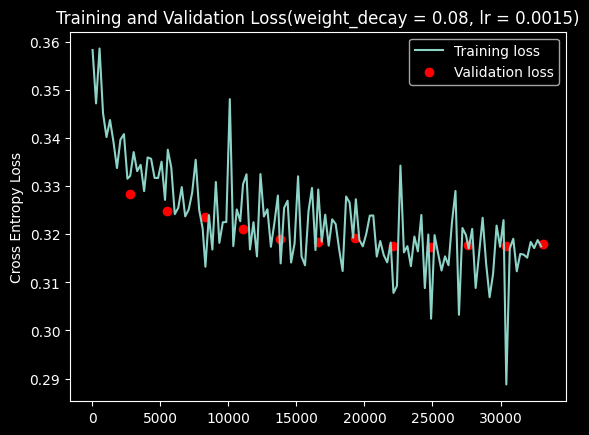

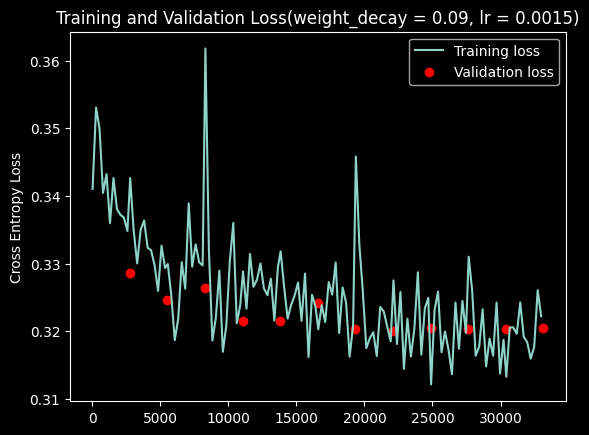

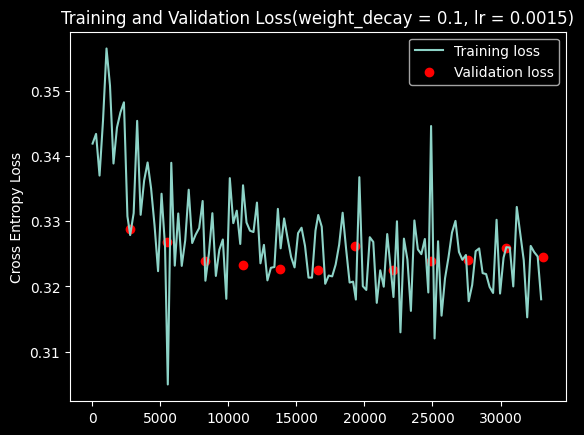

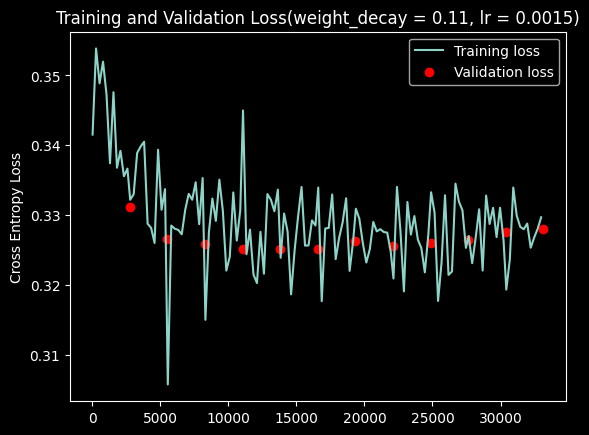

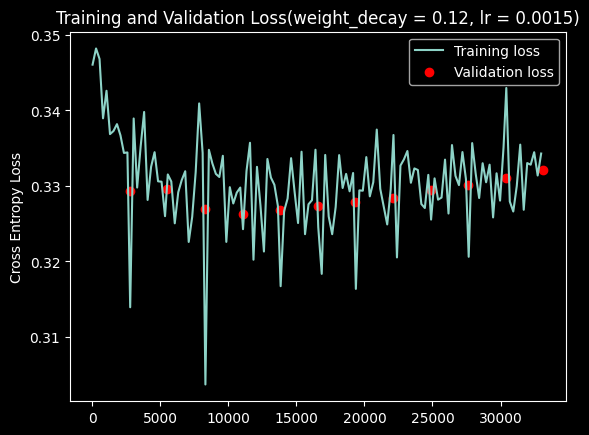

In [32]:
%matplotlib inline

# model = models.resnet18(pretrained=True)
# for param in model.parameters():   
#     param.requires_grad = False
# model.fc = nn.Sequential(
#     nn.Linear(model.fc.in_features, out_features=256, bias=True),
#     nn.ReLU(inplace=True),
#     nn.Dropout(p=0.5, inplace=False),
#     nn.Linear(in_features=256, out_features=2, bias=True),
#     nn.Softmax()
#     )



lr_rate = 0.0015
moment = 0.9
weight_dec = [0.08, 0.09,0.1, 0.11, 0.12]
num_of_epoch = 12
batch_size = 32
logging_period = 8
# criterion = nn.CrossEntropyLoss()
# optimizer =  optim.SGD(model.parameters(), lr=lr_rate, momentum=moment, weight_decay=weight_dec)

result_list = {}

for weight in weight_dec:

    model =  models.vgg16(pretrained=True)

    model.classifier[6] = nn.Sequential(
        nn.Linear(in_features = model.classifier[6].in_features, out_features = 2, bias = True),
        nn.Softmax(dim=1)
    )

    print('===================  Weight decay = {}, lr = {} ==================='.format(weight, lr_rate))    
    result_list[weight] = train( model, tr, val, batch_size, lr_rate, moment, weight, num_of_epoch, logging_period)

print(result_list)


In [33]:


#test(best_filename, ts, batch_size)


# Result archiving

model =  models.vgg16(pretrained=True)

model.classifier[6] = nn.Sequential(
    nn.Linear(in_features = model.classifier[6].in_features, out_features = 2, bias = True),
    nn.Softmax(dim=1)
)

lr_rate = 0.0015
moment = 0.9
weight_dec = [0.08, 0.09,0.1, 0.11, 0.12]
num_of_epoch = 12
batch_size = 32
logging_period = 8


- 
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (18): ReLU(inplace=True)
    (19): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (20): ReLU(inplace=True)
    (21): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (22): ReLU(inplace=True)
    (23): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (24): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (25): ReLU(inplace=True)
    (26): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (27): ReLU(inplace=True)
    (28): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (29): ReLU(inplace=True)
    (30): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(7, 7))
  (classifier): Sequential(
    (0): Linear(in_features=25088, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=4096, out_features=4096, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Sequential(
      (0): Linear(in_features=4096, out_features=2, bias=True)
      (1): Softmax(dim=1)
    )
  )
)



(W_decay: F-1 score)
{0.08: 0.6743849493487699, 0.09: 0.6902173913043478, 0.1: 0.6568047337278107, 0.11: 0.6578947368421052, 0.12: 0.6437125748502993}

### (1) 0.08: 0.6743849493487699
![Alt text](image-87.png) 
- Recall: 0.652661
Precision: 0.697605
F1 Score: 0.674385
Accuracy: 0.674385

### (2) 0.09: 0.6902173913043478
![Alt text](image-88.png)
- Recall: 0.711485
Precision: 0.670185
F1 Score: 0.690217
Accuracy: 0.670043

### (3) 0.1: 0.6568047337278107
![Alt text](image-89.png) 
- Recall: 0.621849
Precision: 0.695925
F1 Score: 0.656805
Accuracy: 0.664255

### (4) 0.11: 0.6578947368421052
![Alt text](image-90.png)
- Recall: 0.630252
Precision: 0.688073
F1 Score: 0.657895
Accuracy: 0.661360

### (5) 0.12: 0.6437125748502993
![Alt text](image-91.png)
- Recall: 0.602241
Precision: 0.691318
F1 Score: 0.643713
Accuracy: 0.655572
